David San<br>
Jacky Gnong

Where's Waldo Finder<br>
CS4662

In [1]:
# "Sequential" models let us define a stack of neural network layers
from keras.models import Sequential

# import the core layers:
from keras.layers import Dense, Dropout, Activation, Flatten

# import some utilities to transform/preprocess our data:
from keras.utils import np_utils

# CNN
from keras.layers import Convolution2D, MaxPooling2D

from keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.utils import resample
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import pandas as pd
import numpy as np
import math

Using TensorFlow backend.


In [2]:
# Helper method to extract 
def appendPics(num_of_files, array, path, hasExten, file):
    for i in range(num_of_files):
        if (hasExten == False):
            file_name = 'wheres-waldo/' + str(path) + '/' + str(i+1) + '.jpg'
        else: 
            file_name = 'wheres-waldo/' + str(path) + '/' + file[i]
        array.append(mpimg.imread(file_name))

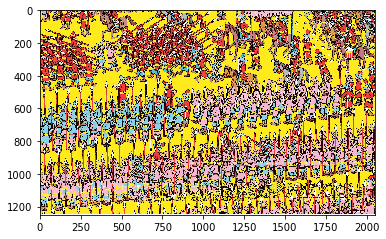

In [3]:
#Read Where's Waldo Files
#Display example picture
#Have training algorithm read files
###We have files for the original picture, [256, 128, 64][C, BW]waldo, and [256, 128, 64][C, BW]not waldo
###Probably want to pair up the original picture with pictures of waldo and not waldo

%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

num_of_original = 19
original_images = []

appendPics(num_of_original, original_images, 'original-images/', False, None)        


plt.imshow(original_images[0])

In [4]:
%matplotlib inline

# Helper function to get spliced image
def splice_image(splice_size, img):    
    spliced_squares = []
    def get_square(x, y, img):
        square = [[0 for i in range(64)] for j in range(64)]
        for row in range(64):
            for col in range(64):
                if (row+y < len(img) and col+x < len(img[row])):
                    square[row][col] = original_images[0][row+y][col+x]
        spliced_squares.append(square)

    for i in range(math.ceil(len(img)/splice_size)):
        for j in range(math.ceil(len(img[i])/splice_size)):
            get_square(j*splice_size, i*splice_size, img)
            
splice_image(64, original_images[0])

In [5]:
# 'answer key' for where the waldos are
# Organized as - original_image_row_column.jpg
imgs = pd.read_csv('wheres-waldo/waldo.csv')

imgs.head()

waldo_64_color waldo_64_bw waldo_64_gray notwaldo_64_color notwaldo_64_bw  \
0      1_4_6.jpg   1_4_6.jpg     1_4_6.jpg         1_0_0.jpg      1_0_0.jpg   
1      1_4_7.jpg   1_4_7.jpg     1_4_7.jpg         1_0_1.jpg      1_0_1.jpg   
2      2_2_5.jpg   2_2_5.jpg     2_2_5.jpg        1_0_10.jpg     1_0_10.jpg   
3      2_7_3.jpg   2_7_3.jpg     2_7_3.jpg        1_0_11.jpg     1_0_11.jpg   
4     3_15_1.jpg  3_15_1.jpg    3_15_1.jpg        1_0_12.jpg     1_0_12.jpg   

  notwaldo_64_gray waldo_128_color waldo_128_bw waldo_128_gray  \
0        1_0_0.jpg       1_2_3.jpg    1_2_3.jpg      1_2_3.jpg   
1        1_0_1.jpg       2_1_2.jpg    2_1_2.jpg      2_1_2.jpg   
2       1_0_10.jpg       2_3_1.jpg    2_3_1.jpg      2_3_1.jpg   
3       1_0_11.jpg       3_7_0.jpg    3_7_0.jpg      3_7_0.jpg   
4       1_0_12.jpg       4_1_5.jpg    4_1_5.jpg      4_1_5.jpg   

  notwaldo_128_color notwaldo_128_bw notwaldo_128_gray waldo_256_color  \
0          1_0_0.jpg       1_0_0.jpg         1_0_0.jpg       1_1_1.jpg   
1          1_0_1.jpg       1_0_1.jpg         1_0_1.jpg       2_0_1.jpg   
2          1_0_2.jpg       1_0_2.jpg         1_0_2.jpg       2_1_0.jpg   
3          1_0_3.jpg       1_0_3.jpg         1_0_3.jpg      21_0_0.jpg   
4          1_0_4.jpg       1_0_4.jpg         1_0_4.jpg       3_3_0.jpg   

  waldo_256_bw waldo_256_gray notwaldo_256_color notwaldo_256_bw  \
0    1_1_1.jpg      1_1_1.jpg          1_0_0.jpg       1_0_0.jpg   
1    2_0_1.jpg      2_0_1.jpg          1_0_1.jpg       1_0_1.jpg   
2    2_1_0.jpg      2_1_0.jpg          1_0_2.jpg       1_0_2.jpg   
3    3_3_0.jpg      3_3_0.jpg          1_0_3.jpg       1_0_3.jpg   
4    4_0_2.jpg      4_0_2.jpg          1_1_0.jpg       1_1_0.jpg   

  notwaldo_256_gray  
0         1_0_0.jpg  
1         1_0_1.jpg  
2         1_0_2.jpg  
3         1_0_3.jpg  
4         1_1_0.jpg

In [6]:
# Create arrays for each of the answers seperated by size and color ----------------
# num_of_waldo_64_color = 39
# num_of_waldo_64_bw = 38
# num_of_waldo_64_gray = 38
# num_of_notwaldo_64_color = 5337
# num_of_notwaldo_64_bw = 5043
# num_of_notwaldo_64_gray = 5338
waldo_64_color = []
waldo_64_bw = []
waldo_64_gray = []
notwaldo_64_color = []
notwaldo_64_bw = []
notwaldo_64_gray = []

# num_of_128_waldo = 27
# num_of_128_notwaldo = 1317
waldo_128_color = []
waldo_128_bw = []
waldo_128_gray = []
notwaldo_128_color = []
notwaldo_128_bw = []
notwaldo_128_gray = []

# num_of_256_waldo = 31
# num_of_256_notwaldo = 286
waldo_256_color = []
waldo_256_bw = []
waldo_256_gray = []
notwaldo_256_color = []
notwaldo_256_bw = []
notwaldo_256_gray = []

#---------------------------------------------------------------------------------

# Gather headers from the 'answers' dataframe to be able to access columns
cols = ['waldo_64_color', 'waldo_64_bw', 'waldo_64_gray', 'notwaldo_64_color', 'notwaldo_64_bw', 'notwaldo_64_gray', 
        'waldo_128_color', 'waldo_128_bw', 'waldo_128_gray', 'notwaldo_128_color', 'notwaldo_128_bw', 'notwaldo_128_gray',
        'waldo_256_color', 'waldo_256_bw', 'waldo_256_gray', 'notwaldo_256_color', 'notwaldo_256_bw', 'notwaldo_256_gray']

# Array to contain how many imgs in that section
nums = []
for i in range(len(cols)):
    nums.append(len(imgs[cols[i]].dropna()))
# print(nums)

# Hold list of arrays to make it easier to iterate through
arrays = [waldo_64_color, waldo_64_bw, waldo_64_gray, notwaldo_64_color, notwaldo_64_bw, notwaldo_64_gray,
          waldo_128_color, waldo_128_bw, waldo_128_gray, notwaldo_128_color, notwaldo_128_bw, notwaldo_128_gray,
          waldo_256_color, waldo_256_bw, waldo_256_gray, notwaldo_256_color, notwaldo_256_bw, notwaldo_256_gray]
paths = ['64/waldo', '64-bw/waldo', '64-gray/waldo', '64/notwaldo', '64-bw/notwaldo', '64-gray/notwaldo', 
         '128/waldo', '128-bw/waldo', '128-gray/waldo', '128/notwaldo', '128-bw/notwaldo', '128-gray/notwaldo', 
         '256/waldo', '256-bw/waldo', '256-gray/waldo', '256/notwaldo', '256-bw/notwaldo', '256-gray/notwaldo']


for i in range(len(nums)):
    appendPics(nums[i], arrays[i], paths[i], True, imgs[cols[i]])

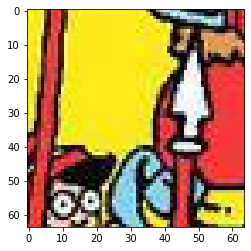

In [7]:
%matplotlib inline     

plt.imshow(waldo_64_color[0])

In [40]:
# y = waldo/notwaldo
# y = 1/0

new_256_list = waldo_64_color.copy()
new_256_list.extend(notwaldo_64_color)
dict = []
for i in range(len(new_256_list)):
    if (i < len(imgs[cols[12]].dropna())):
        dict.append(1) # indicates waldo
    else:
        dict.append(0) # indicates notwaldo


waldo_256_colorss = pd.DataFrame({'images': new_256_list, 'is_waldo':dict})
    
print(waldo_256_colorss.head())
print(waldo_256_colorss.shape)

                                              images  is_waldo
0  [[[250, 242, 35], [245, 234, 18], [246, 225, 0...         1
1  [[[160, 20, 29], [215, 65, 64], [240, 65, 44],...         1
2  [[[151, 148, 131], [200, 194, 180], [196, 183,...         1
3  [[[155, 146, 141], [158, 149, 144], [168, 161,...         1
4  [[[119, 130, 122], [107, 117, 108], [121, 124,...         1
(5376, 2)


In [42]:
# Seperate into individual pixels

#something about the size of the images
col = []
for i in range(math.ceil(len(new_256_list)/3)):
    waldo_256_colorss[3*i] = waldo_256_colorss['images'][0][0][i][0] 
    waldo_256_colorss[3*i+1] = waldo_256_colorss['images'][0][0][i][1]
    waldo_256_colorss[3*i+2] = waldo_256_colorss['images'][0][0][i][2]
print(waldo_256_colorss['images'][0][0][0][0]) #['images'][imageRow][image][pixel][rgb]

IndexError: index 64 is out of bounds for axis 0 with size 64

In [10]:
# Randomly splitting the original dataset into training set and testing set:
X = waldo_256_colorss['images']
y = waldo_256_colorss['is_waldo']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

print(X_train[:5])
print(y_train[:5])
print(X_train.shape)
print(y_train.shape)

5303    [[[168, 168, 58], [174, 172, 71], [189, 184, 1...
700     [[[93, 71, 30], [227, 213, 140], [234, 236, 10...
231     [[[168, 81, 89], [44, 0, 0], [144, 143, 60], [...
434     [[[158, 118, 56], [166, 125, 59], [198, 154, 8...
2085    [[[249, 249, 249], [255, 255, 255], [248, 248,...
Name: 0, dtype: object
5303    0
700     0
231     0
434     0
2085    0
Name: is_waldo, dtype: int64
(4300,)
(4300,)


In [11]:
num_of_pixels = 64 * 64 * 3


# print(waldo_256_colorss['images'])
for i in range(len(waldo_256_colorss['images'])):
    print(waldo_256_colorss['images'][i])
    waldo_256_colorss['images'][i] = waldo_256_colorss['images'][i].reshape(num_of_pixels)

[[[250 242  35]
  [245 234  18]
  [246 225   0]
  ...
  [ 81  24   7]
  [150  60  34]
  [192  87  57]]

 [[247 239  32]
  [255 246  32]
  [247 229   0]
  ...
  [ 85   7   3]
  [162  49  35]
  [230  99  81]]

 [[237 231  25]
  [255 250  38]
  [249 230   4]
  ...
  [100   0   1]
  [187  22  36]
  [224  39  47]]

 ...

 [[ 95   9  20]
  [197  78  82]
  [238  52  40]
  ...
  [235 226  33]
  [250 242  37]
  [232 222  13]]

 [[113  19  33]
  [218  93  99]
  [225  39  27]
  ...
  [231 243  83]
  [242 249 111]
  [234 239 111]]

 [[160  62  77]
  [188  61  68]
  [248  60  49]
  ...
  [179 200  59]
  [191 206 101]
  [ 70  82   0]]]
[[[160  20  29]
  [215  65  64]
  [240  65  44]
  ...
  [ 24   3   2]
  [ 29   0   3]
  [ 27   0   0]]

 [[204  58  68]
  [213  59  59]
  [234  63  43]
  ...
  [ 93  26  35]
  [111  37  50]
  [120  42  56]]

 [[222  62  70]
  [235  75  75]
  [239  76  59]
  ...
  [212  55  82]
  [224  61  92]
  [229  61  94]]

 ...

 [[  9   9   0]
  [ 65  63  51]
  [248 235 226]
  ..

[[[219 154  38]
  [216 153  40]
  [208 149  47]
  ...
  [255 235  27]
  [255 235  27]
  [255 235  27]]

 [[232 168  80]
  [238 176  91]
  [221 162  86]
  ...
  [255 235  27]
  [255 235  27]
  [255 235  27]]

 [[178 115  82]
  [167 106  77]
  [157  99  77]
  ...
  [255 235  27]
  [255 235  27]
  [255 235  27]]

 ...

 [[239 242 235]
  [254 255 253]
  [244 244 246]
  ...
  [252 255 242]
  [253 255 244]
  [252 255 242]]

 [[249 255 241]
  [251 255 243]
  [251 253 242]
  ...
  [244 254 245]
  [246 253 246]
  [244 254 245]]

 [[248 255 238]
  [236 243 225]
  [254 255 241]
  ...
  [246 255 251]
  [246 255 251]
  [246 255 251]]]
[[[139 143 110]
  [131 129 106]
  [200 187 181]
  ...
  [204  85  87]
  [232  50  65]
  [246  30  53]]

 [[232 238 224]
  [247 248 240]
  [255 246 249]
  ...
  [125  37  27]
  [219  70  92]
  [249  67 107]]

 [[245 255 255]
  [245 253 255]
  [244 247 255]
  ...
  [ 29   1   0]
  [118  32  67]
  [165  51 121]]

 ...

 [[234 224 129]
  [ 74  67   0]
  [ 44  42   0]
  ..

c:\users\davet\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys



[[[253 234  33]
  [253 235  31]
  [255 234  29]
  ...
  [217 185 188]
  [227 191 175]
  [255 226 198]]

 [[253 234  33]
  [253 235  31]
  [255 234  29]
  ...
  [242 209 220]
  [237 201 201]
  [245 208 202]]

 [[253 234  33]
  [253 235  31]
  [255 234  29]
  ...
  [185 151 178]
  [255 221 255]
  [252 209 252]]

 ...

 [[253 240  14]
  [251 239  17]
  [251 237  24]
  ...
  [252 245  94]
  [239 233  35]
  [246 242  20]]

 [[253 240  14]
  [251 239  17]
  [251 237  24]
  ...
  [255 231  90]
  [255 229  37]
  [249 226   8]]

 [[253 240  14]
  [251 239  17]
  [251 237  24]
  ...
  [222 170  34]
  [255 234  43]
  [255 232  15]]]
[[[255 235  20]
  [255 235  27]
  [253 233  40]
  ...
  [ 63   6   0]
  [114  88  61]
  [217 208 177]]

 [[255 235  22]
  [255 235  27]
  [253 233  38]
  ...
  [151  61  50]
  [ 92  26  10]
  [ 53   2   0]]

 [[255 235  24]
  [255 235  27]
  [252 234  36]
  ...
  [228  71  78]
  [206  61  68]
  [180  44  48]]

 ...

 [[ 26   0   0]
  [ 54  19  15]
  [168 127 125]
  .

  [165  80  85]]]
[[[189 148 130]
  [186 144 130]
  [181 137 136]
  ...
  [ 49  13  17]
  [ 34   3  11]
  [ 24   0   8]]

 [[183 141 119]
  [192 150 134]
  [187 141 143]
  ...
  [195 148 158]
  [164 121 138]
  [ 68  29  47]]

 [[187 144 112]
  [204 161 142]
  [189 139 148]
  ...
  [180 112 135]
  [199 132 163]
  [234 171 202]]

 ...

 [[154  77  67]
  [157  80  74]
  [150  71  74]
  ...
  [253 233  25]
  [253 233  25]
  [253 233  25]]

 [[151  69  81]
  [177  95 109]
  [155  72  90]
  ...
  [253 233  25]
  [253 233  25]
  [253 233  25]]

 [[107  23  46]
  [168  84 107]
  [156  70  97]
  ...
  [253 233  25]
  [253 233  25]
  [253 233  25]]]
[[[ 33   0   0]
  [ 93  51  52]
  [159 112 120]
  ...
  [223 223  27]
  [227 238  72]
  [225 244  92]]

 [[ 83  43  44]
  [ 42   0   4]
  [ 88  41  51]
  ...
  [233 225  54]
  [218 224 102]
  [ 57  71   0]]

 [[103  62  78]
  [ 32   0   4]
  [ 49   2  18]
  ...
  [249 229 106]
  [ 12   6   0]
  [ 20  23  32]]

 ...

 [[255  51  75]
  [250  48  62]
  

  [153 121  74]]]
[[[151 128   0]
  [205 186  45]
  [245 232  92]
  ...
  [255 200 180]
  [223 160 143]
  [255 192 175]]

 [[126 102   0]
  [202 182  51]
  [255 255 134]
  ...
  [246 191 170]
  [255 206 185]
  [241 176 156]]

 [[149 119   7]
  [155 129  18]
  [230 212 100]
  ...
  [221 170 143]
  [227 170 143]
  [250 189 161]]

 ...

 [[117  66  47]
  [179 123 106]
  [208 142 126]
  ...
  [198 162  88]
  [203 169  98]
  [196 161  93]]

 [[133  77  62]
  [104  45  29]
  [108  41  25]
  ...
  [114  84  20]
  [111  82  24]
  [106  80  23]]

 [[116  58  44]
  [ 97  35  20]
  [125  55  43]
  ...
  [127 103  43]
  [112  86  35]
  [127 104  54]]]
[[[116  39  31]
  [138  61  53]
  [180 106  95]
  ...
  [209 239 247]
  [200 224 234]
  [162 185 193]]

 [[147  73  64]
  [140  66  57]
  [195 123 111]
  ...
  [173 205 218]
  [156 184 196]
  [122 149 160]]

 [[118  50  39]
  [151  83  72]
  [220 152 139]
  ...
  [113 148 170]
  [131 162 183]
  [126 157 177]]

 ...

 [[135 154  90]
  [179 200 135]
  

[[[128 116  66]
  [115 102  47]
  [197 177 116]
  ...
  [176 225 203]
  [191 229 208]
  [177 210 191]]

 [[107  97  48]
  [124 111  59]
  [206 187 128]
  ...
  [171 219 197]
  [159 196 178]
  [196 229 210]]

 [[157 148 105]
  [ 81  71  22]
  [165 148  92]
  ...
  [176 221 200]
  [179 213 196]
  [201 232 216]]

 ...

 [[204 164 156]
  [242 208 198]
  [148 121 110]
  ...
  [130 127  94]
  [ 79  73  37]
  [111 103  66]]

 [[118  63  58]
  [235 186 179]
  [246 207 200]
  ...
  [ 84  79  59]
  [ 50  42  23]
  [ 87  79  60]]

 [[127  66  61]
  [143  88  83]
  [202 157 151]
  ...
  [148 142 128]
  [ 85  76  67]
  [ 85  75  66]]]
[[[164 157 149]
  [ 74  67  59]
  [ 79  69  60]
  ...
  [186 180 154]
  [ 62  51  23]
  [113 100  68]]

 [[207 203 194]
  [128 121 111]
  [ 96  87  78]
  ...
  [188 182 158]
  [120 109  81]
  [ 50  37   5]]

 [[139 137 125]
  [178 174 162]
  [188 182 170]
  ...
  [187 181 157]
  [107  96  68]
  [ 71  58  26]]

 ...

 [[167 216 210]
  [157 212 206]
  [146 213 204]
  ..

  [231 166  98]]]
[[[243  49  76]
  [255  63  92]
  [238  47  78]
  ...
  [219 174 109]
  [220 172 110]
  [219 171 109]]

 [[236  58  80]
  [220  44  65]
  [249  75 100]
  ...
  [221 173 109]
  [220 170 109]
  [218 168 107]]

 [[226  85  93]
  [205  65  74]
  [207  65  79]
  ...
  [223 172 109]
  [223 169 107]
  [222 166 105]]

 ...

 [[ 15 177 216]
  [ 30 172 210]
  [ 34 138 177]
  ...
  [204 192 176]
  [228 213 194]
  [226 209 189]]

 [[ 21 166 185]
  [ 43 172 191]
  [ 58 153 171]
  ...
  [250 237 220]
  [255 240 220]
  [224 206 184]]

 [[ 36 173 183]
  [ 53 176 184]
  [ 79 170 175]
  ...
  [236 221 202]
  [218 202 179]
  [255 247 223]]]
[[[244  48  70]
  [233  61  75]
  [220  89  94]
  ...
  [ 18  16  17]
  [ 77  75  76]
  [145 143 144]]

 [[237  54  74]
  [221  59  74]
  [211  91  93]
  ...
  [  7   7   7]
  [ 34  34  34]
  [114 114 114]]

 [[221  60  78]
  [210  68  80]
  [202  98  99]
  ...
  [ 18  20  19]
  [  1   3   2]
  [ 20  22  21]]

 ...

 [[102 115 124]
  [ 67  81  90]
  

  [177 172 140]]]
[[[226 214 234]
  [247 240 255]
  [233 231 244]
  ...
  [ 87 134 126]
  [121 170 151]
  [155 207 184]]

 [[207 200 216]
  [245 241 255]
  [237 240 249]
  ...
  [  0  66  65]
  [  0  42  28]
  [  0  59  38]]

 [[191 194 201]
  [248 253 255]
  [235 246 248]
  ...
  [ 35 138 153]
  [ 43 142 139]
  [  7 103  91]]

 ...

 [[252 247 241]
  [247 244 237]
  [255 255 251]
  ...
  [229  68  83]
  [245  53  76]
  [255  54  82]]

 [[249 246 239]
  [236 236 228]
  [253 255 250]
  ...
  [229  64  81]
  [251  55  77]
  [255  45  68]]

 [[255 255 248]
  [224 224 216]
  [239 241 236]
  ...
  [234  67  87]
  [255  69  90]
  [255  55  77]]]
[[[255 252 253]
  [236 230 230]
  [239 237 240]
  ...
  [227  70  81]
  [236  72  73]
  [245  80  74]]

 [[245 236 237]
  [241 235 235]
  [252 252 254]
  ...
  [230  69  75]
  [237  71  71]
  [239  70  65]]

 [[251 245 245]
  [245 244 242]
  [251 255 255]
  ...
  [232  69  62]
  [248  74  73]
  [243  65  65]]

 ...

 [[255 250 255]
  [243 245 255]
  

  [178 219 237]]]
[[[101  38   5]
  [139  65  38]
  [188  92  78]
  ...
  [202 222 233]
  [238 255 255]
  [129 149 138]]

 [[177 101  78]
  [182  95  78]
  [188  84  75]
  ...
  [220 240 249]
  [149 169 160]
  [ 33  54  35]]

 [[190  84  84]
  [200  87  89]
  [190  65  71]
  ...
  [166 184 188]
  [ 31  50  28]
  [  0  12   0]]

 ...

 [[223 197 200]
  [152 126 127]
  [ 96  70  71]
  ...
  [250 250  78]
  [232 234  65]
  [217 220  53]]

 [[231 206 210]
  [255 234 238]
  [255 247 251]
  ...
  [228 224  41]
  [232 228  58]
  [242 239  72]]

 [[232 207 213]
  [215 190 196]
  [202 180 183]
  ...
  [229 224  36]
  [240 234  60]
  [234 229  63]]]
[[[179 200 191]
  [224 244 233]
  [ 88 106  94]
  ...
  [159 139 141]
  [183 172 178]
  [255 248 255]]

 [[184 204 195]
  [233 250 240]
  [151 167 156]
  ...
  [  4   0   2]
  [ 51  54  61]
  [ 73  80  90]]

 [[189 204 197]
  [192 205 196]
  [106 118 108]
  ...
  [ 11  30  36]
  [ 48  78  89]
  [  4  40  54]]

 ...

 [[151  75  51]
  [ 97  21   0]
  

  [248 248 248]]]
[[[248 248 248]
  [248 248 248]
  [248 248 248]
  ...
  [242 252 244]
  [242 252 243]
  [242 254 244]]

 [[248 248 248]
  [248 248 248]
  [248 248 248]
  ...
  [244 251 244]
  [244 251 243]
  [243 253 244]]

 [[248 248 248]
  [248 248 248]
  [248 248 248]
  ...
  [247 249 244]
  [247 250 243]
  [248 251 244]]

 ...

 [[240 253 223]
  [157 172 139]
  [115 137  99]
  ...
  [ 40 147  51]
  [ 50 165  70]
  [ 56 176  79]]

 [[192 213 172]
  [126 152 107]
  [ 99 131  82]
  ...
  [ 48 158  61]
  [ 56 171  76]
  [ 53 173  76]]

 [[123 149 102]
  [ 98 128  78]
  [ 72 107  53]
  ...
  [ 60 170  73]
  [ 65 180  85]
  [ 53 173  76]]]
[[[ 94 112  86]
  [102 142 107]
  [ 50 128  78]
  ...
  [ 60 176  69]
  [ 59 178  74]
  [ 57 178  73]]

 [[ 71  90  62]
  [ 93 131  94]
  [ 73 150  98]
  ...
  [ 66 183  76]
  [ 63 185  76]
  [ 61 184  77]]

 [[139 159 124]
  [ 94 131  90]
  [ 62 131  77]
  ...
  [ 63 184  71]
  [ 61 185  71]
  [ 58 185  70]]

 ...

 [[147 188  92]
  [138 182  84]
  

  [107  92  85]]]
[[[156 220 245]
  [156 220 245]
  [156 220 245]
  ...
  [154 218 243]
  [154 218 243]
  [154 218 243]]

 [[156 220 245]
  [156 220 245]
  [156 220 245]
  ...
  [154 218 243]
  [154 218 243]
  [154 218 243]]

 [[156 220 245]
  [156 220 245]
  [156 220 245]
  ...
  [154 218 243]
  [154 218 243]
  [154 218 243]]

 ...

 [[159 217 239]
  [159 217 239]
  [159 217 239]
  ...
  [152 217 235]
  [154 219 237]
  [155 220 238]]

 [[161 217 240]
  [161 217 240]
  [161 217 240]
  ...
  [151 217 233]
  [153 219 235]
  [155 221 237]]

 [[162 218 241]
  [162 218 241]
  [162 218 241]
  ...
  [157 223 239]
  [162 228 244]
  [165 231 247]]]
[[[206 220 246]
  [205 221 246]
  [204 220 245]
  ...
  [199 228 244]
  [209 235 250]
  [215 238 254]]

 [[226 238 255]
  [224 239 255]
  [221 238 255]
  ...
  [215 241 254]
  [223 245 255]
  [228 247 255]]

 [[239 251 255]
  [238 250 255]
  [236 249 255]
  ...
  [228 246 255]
  [235 247 255]
  [238 248 255]]

 ...

 [[182 205 101]
  [169 192  88]
  

  [127 104  54]]]
[[[116  39  31]
  [138  61  53]
  [180 106  95]
  ...
  [209 239 247]
  [200 224 234]
  [162 185 193]]

 [[147  73  64]
  [140  66  57]
  [195 123 111]
  ...
  [173 205 218]
  [156 184 196]
  [122 149 160]]

 [[118  50  39]
  [151  83  72]
  [220 152 139]
  ...
  [113 148 170]
  [131 162 183]
  [126 157 177]]

 ...

 [[135 154  90]
  [179 200 135]
  [177 199 135]
  ...
  [108 102  66]
  [ 73  67  31]
  [173 167 131]]

 [[152 173 108]
  [200 221 156]
  [206 231 165]
  ...
  [ 67  61  25]
  [ 49  43   7]
  [135 129  93]]

 [[207 228 163]
  [175 197 132]
  [184 209 143]
  ...
  [ 60  54  18]
  [ 72  66  30]
  [ 50  44   8]]]
[[[194 211 157]
  [139 158 103]
  [117 138  82]
  ...
  [ 66  53  21]
  [ 68  58  23]
  [ 85  75  40]]

 [[193 210 156]
  [186 205 150]
  [177 198 142]
  ...
  [ 57  44  12]
  [ 78  68  33]
  [ 88  78  43]]

 [[209 223 170]
  [195 212 158]
  [185 206 150]
  ...
  [ 60  47  15]
  [ 88  78  43]
  [ 65  55  20]]

 ...

 [[148  57  36]
  [180  85  65]
  

  [137 170 161]]]
[[[ 93  93  65]
  [144 140 111]
  [152 142 115]
  ...
  [144 168 146]
  [127 150 134]
  [161 183 171]]

 [[ 83  83  55]
  [142 138 109]
  [117 105  79]
  ...
  [ 58  80  57]
  [ 70  91  76]
  [111 131 120]]

 [[ 69  68  40]
  [160 155 126]
  [141 127 101]
  ...
  [143 162 140]
  [122 140 126]
  [ 95 113 101]]

 ...

 [[227 178  86]
  [235 184  92]
  [231 178  82]
  ...
  [240 175  49]
  [225 158  18]
  [255 198  53]]

 [[250 195  92]
  [226 169  64]
  [155  97   0]
  ...
  [255 186  54]
  [255 184  38]
  [225 152   0]]

 [[210 152  42]
  [201 144  31]
  [119  58   0]
  ...
  [234 161  23]
  [253 177  29]
  [231 154   0]]]
[[[228 166  63]
  [217 155  54]
  [196 133  38]
  ...
  [245 170  51]
  [221 142  13]
  [240 158  23]]

 [[239 182  77]
  [233 176  73]
  [186 128  29]
  ...
  [231 160  46]
  [255 186  59]
  [255 184  53]]

 [[231 182  77]
  [226 177  72]
  [149  97   0]
  ...
  [231 167  61]
  [255 185  64]
  [219 146  18]]

 ...

 [[115 131  82]
  [110 128  78]
  

  [219 205 202]]]
[[[247  33  43]
  [244  38  48]
  [235  43  56]
  ...
  [  4   5   7]
  [110 116 116]
  [233 242 241]]

 [[248  34  46]
  [255  50  63]
  [248  56  69]
  ...
  [ 15  14  12]
  [ 53  55  54]
  [160 165 161]]

 [[242  26  41]
  [245  37  51]
  [233  38  54]
  ...
  [ 92  83  78]
  [ 37  29  26]
  [ 77  72  66]]

 ...

 [[241 245  96]
  [245 250  95]
  [228 235  69]
  ...
  [ 76 108  93]
  [207 239 226]
  [161 195 181]]

 [[169 172  91]
  [187 193 105]
  [172 180  77]
  ...
  [135 168 151]
  [194 226 211]
  [ 90 124 108]]

 [[ 47  50   3]
  [ 40  45   0]
  [ 21  31   0]
  ...
  [188 221 204]
  [176 208 193]
  [ 44  78  62]]]
[[[183 180 223]
  [173 172 212]
  [151 153 191]
  ...
  [165 192 183]
  [ 75  98  90]
  [  0  18  10]]

 [[198 198 232]
  [197 200 231]
  [188 195 223]
  ...
  [162 188 179]
  [  7  30  22]
  [ 16  39  31]]

 [[ 28  38  50]
  [ 90 103 112]
  [165 182 192]
  ...
  [ 83 109 100]
  [  0  16   9]
  [ 87 108 101]]

 ...

 [[184 227 220]
  [158 201 194]
  

  [ 72  14  28]]]
[[[230 198 187]
  [160 130 120]
  [ 97  66  61]
  ...
  [ 79  52  59]
  [ 37  11  24]
  [ 27   3  17]]

 [[194 164 154]
  [107  78  70]
  [ 46  17  13]
  ...
  [105  79  82]
  [ 18   0   1]
  [ 19   0   6]]

 [[224 197 190]
  [107  82  77]
  [ 28   3   0]
  ...
  [ 59  31  28]
  [156 130 133]
  [ 39  14  18]]

 ...

 [[227 167 115]
  [227 167 115]
  [227 167 115]
  ...
  [181 190 189]
  [200 210 209]
  [165 177 175]]

 [[227 167 115]
  [227 167 115]
  [227 167 115]
  ...
  [182 191 190]
  [187 197 196]
  [181 191 190]]

 [[227 167 115]
  [227 167 115]
  [227 167 115]
  ...
  [173 182 181]
  [168 177 176]
  [193 203 202]]]
[[[224 168 119]
  [224 168 119]
  [224 168 117]
  ...
  [200 210 211]
  [201 212 216]
  [169 180 184]]

 [[224 168 121]
  [224 168 119]
  [224 168 119]
  ...
  [189 199 200]
  [164 174 176]
  [172 183 187]]

 [[224 167 122]
  [224 168 121]
  [224 168 121]
  ...
  [ 59  64  67]
  [  8  16  19]
  [ 26  36  38]]

 ...

 [[243 204 205]
  [ 71  37  35]
  

  [178 219 237]]]
[[[101  38   5]
  [139  65  38]
  [188  92  78]
  ...
  [202 222 233]
  [238 255 255]
  [129 149 138]]

 [[177 101  78]
  [182  95  78]
  [188  84  75]
  ...
  [220 240 249]
  [149 169 160]
  [ 33  54  35]]

 [[190  84  84]
  [200  87  89]
  [190  65  71]
  ...
  [166 184 188]
  [ 31  50  28]
  [  0  12   0]]

 ...

 [[223 197 200]
  [152 126 127]
  [ 96  70  71]
  ...
  [250 250  78]
  [232 234  65]
  [217 220  53]]

 [[231 206 210]
  [255 234 238]
  [255 247 251]
  ...
  [228 224  41]
  [232 228  58]
  [242 239  72]]

 [[232 207 213]
  [215 190 196]
  [202 180 183]
  ...
  [229 224  36]
  [240 234  60]
  [234 229  63]]]
[[[179 200 191]
  [224 244 233]
  [ 88 106  94]
  ...
  [159 139 141]
  [183 172 178]
  [255 248 255]]

 [[184 204 195]
  [233 250 240]
  [151 167 156]
  ...
  [  4   0   2]
  [ 51  54  61]
  [ 73  80  90]]

 [[189 204 197]
  [192 205 196]
  [106 118 108]
  ...
  [ 11  30  36]
  [ 48  78  89]
  [  4  40  54]]

 ...

 [[151  75  51]
  [ 97  21   0]
  

  [123 149  76]]]
[[[144 140 129]
  [158 154 145]
  [157 150 144]
  ...
  [201 212 169]
  [182 193 153]
  [ 75  85  48]]

 [[139 132 124]
  [184 177 171]
  [196 188 185]
  ...
  [200 212 166]
  [120 131  89]
  [ 80  91  49]]

 [[ 81  72  67]
  [130 122 119]
  [172 163 164]
  ...
  [183 196 143]
  [ 77  86  39]
  [115 124  77]]

 ...

 [[191 137 135]
  [189 136 132]
  [184 131 125]
  ...
  [ 25  22   0]
  [113 102  74]
  [ 66  49  29]]

 [[190 139 135]
  [200 149 145]
  [183 130 124]
  ...
  [ 25  22   0]
  [110  99  71]
  [ 48  31  11]]

 [[131  82  77]
  [195 144 140]
  [201 148 142]
  ...
  [ 24  21   0]
  [122 111  83]
  [ 64  47  27]]]
[[[110  65  62]
  [173 128 125]
  [140  90  89]
  ...
  [ 29  28   0]
  [107 100  84]
  [ 51  43  32]]

 [[122  77  74]
  [192 147 144]
  [145  95  94]
  ...
  [  6   2   0]
  [ 34  27  11]
  [ 29  21  10]]

 [[118  73  70]
  [181 136 133]
  [196 146 145]
  ...
  [ 59  52  33]
  [ 28  18   8]
  [ 39  29  20]]

 ...

 [[ 94 148 176]
  [110 157 185]
  

  [241 143  34]]]
[[[  0  47  44]
  [  0  55  46]
  [ 11 118  98]
  ...
  [229 165  94]
  [241 148  55]
  [253 148  43]]

 [[  5  81  71]
  [ 53 145 130]
  [ 51 175 149]
  ...
  [213 149  78]
  [239 150  56]
  [255 153  48]]

 [[ 57 177 150]
  [ 14 145 114]
  [ 24 178 140]
  ...
  [227 167  95]
  [230 146  50]
  [241 144  39]]

 ...

 [[  7  27  26]
  [ 80 127 119]
  [ 70 174 151]
  ...
  [172 198 235]
  [172 197 237]
  [166 191 231]]

 [[  0  17  16]
  [ 33  83  74]
  [ 52 147 127]
  ...
  [152 183 229]
  [162 193 240]
  [155 186 233]]

 [[ 41  71  69]
  [  0  27  20]
  [  0  71  53]
  ...
  [173 207 255]
  [162 193 247]
  [157 188 242]]]
[[[253 189 224]
  [234 180 216]
  [ 63  25  66]
  ...
  [157 186 228]
  [167 194 237]
  [161 188 231]]

 [[235 172 203]
  [252 196 231]
  [220 180 217]
  ...
  [157 189 228]
  [158 187 227]
  [165 194 234]]

 [[255 194 219]
  [232 176 203]
  [239 192 228]
  ...
  [169 205 237]
  [153 189 221]
  [154 190 222]]

 ...

 [[248 154  54]
  [248 154  54]
  

  [158 110 126]]]
[[[229 222 108]
  [ 80  69   0]
  [180 158  46]
  ...
  [150  94  93]
  [150  95  92]
  [150  95  92]]

 [[202 194  85]
  [ 82  70   0]
  [223 203  90]
  ...
  [150  94  93]
  [150  95  92]
  [150  95  92]]

 [[170 162  61]
  [ 87  76   0]
  [247 231 118]
  ...
  [150  94  93]
  [152  94  93]
  [152  94  93]]

 ...

 [[244 218 123]
  [255 229 149]
  [118  87  33]
  ...
  [  0 156 217]
  [  5 171 229]
  [ 17 190 246]]

 [[ 81  52   0]
  [229 198 131]
  [ 96  64  15]
  ...
  [ 12 160 224]
  [ 27 151 225]
  [ 37 148 227]]

 [[100  70   0]
  [ 85  53   0]
  [ 49  17   0]
  ...
  [ 12 155 221]
  [ 37 137 222]
  [ 49 130 221]]]
[[[152  67  86]
  [184  94 103]
  [175  72  65]
  ...
  [ 64 158 186]
  [ 31  95 123]
  [ 25  75 102]]

 [[108   9  30]
  [196  99 110]
  [180  83  74]
  ...
  [  0  92 115]
  [  0  23  41]
  [ 40 109 125]]

 [[219  91 116]
  [167  52  65]
  [ 99  16   2]
  ...
  [  0  54  67]
  [ 38 142 141]
  [ 61 172 165]]

 ...

 [[207 106 110]
  [170  61  66]
  

  [ 75  74  70]]]
[[[252 237 180]
  [252 237 180]
  [253 236 182]
  ...
  [ 46  49   4]
  [ 14  26   0]
  [ 74  90  17]]

 [[252 237 180]
  [252 237 180]
  [253 236 182]
  ...
  [105 111  65]
  [ 14  25   0]
  [113 128  69]]

 [[252 237 182]
  [252 237 182]
  [253 236 182]
  ...
  [207 215 166]
  [ 30  40   3]
  [121 135 102]]

 ...

 [[134 154  91]
  [159 180 113]
  [186 208 133]
  ...
  [239  94  97]
  [216  77  80]
  [168  32  36]]

 [[175 194 130]
  [156 175 109]
  [ 89 109  38]
  ...
  [230  91  96]
  [201  68  73]
  [153  22  28]]

 [[ 64  83  17]
  [ 52  72   3]
  [  9  29   0]
  ...
  [224  89  95]
  [197  66  72]
  [157  30  37]]]
[[[108 125  73]
  [171 187 140]
  [127 144 102]
  ...
  [223  81  95]
  [133   4  22]
  [187  64  84]]

 [[251 255 220]
  [132 147 104]
  [ 54  68  33]
  ...
  [199  65  76]
  [127   5  20]
  [211  96 113]]

 [[209 218 187]
  [155 164 135]
  [ 33  43  18]
  ...
  [174  53  60]
  [119  12  22]
  [224 124 136]]

 ...

 [[ 20 113 183]
  [ 13 110 178]
  

  [249 247 252]]]
[[[205 129 129]
  [185 120 114]
  [142  98  85]
  ...
  [255 237 239]
  [255 240 247]
  [255 239 247]]

 [[130  50  51]
  [121  46  43]
  [101  37  28]
  ...
  [106  88  88]
  [103  81  83]
  [143 118 122]]

 [[175  85  87]
  [171  75  77]
  [197  90  96]
  ...
  [140 130 121]
  [164 151 145]
  [ 64  51  45]]

 ...

 [[255 245 255]
  [196 183 192]
  [129 118 124]
  ...
  [ 72  41  23]
  [ 85  45  35]
  [ 99  56  49]]

 [[255 238 255]
  [255 247 255]
  [255 247 248]
  ...
  [179 154 132]
  [ 83  45  34]
  [ 94  49  43]]

 [[247 229 255]
  [255 249 255]
  [255 247 248]
  ...
  [250 230 206]
  [138 100  89]
  [138  93  87]]]
[[[255 251 255]
  [227 223 238]
  [243 242 247]
  ...
  [255 233 199]
  [239 216 175]
  [229 208 165]]

 [[246 239 255]
  [255 252 255]
  [234 232 235]
  ...
  [252 224 187]
  [222 199 158]
  [117  99  53]]

 [[252 244 255]
  [239 231 242]
  [252 246 248]
  ...
  [165 137  98]
  [ 85  64  21]
  [171 155 106]]

 ...

 [[246 211 183]
  [237 203 176]
  

  [ 69  60  43]]]
[[[169  98 112]
  [127  67  75]
  [ 78  38  39]
  ...
  [215 172 104]
  [209 166  88]
  [184 139  58]]

 [[141  80  88]
  [ 95  43  47]
  [ 81  47  45]
  ...
  [241 197 126]
  [219 173  95]
  [145  99  14]]

 [[109  65  64]
  [ 43   6   0]
  [ 63  41  30]
  ...
  [101  55   0]
  [206 158  73]
  [230 180  91]]

 ...

 [[106 109 126]
  [ 84  90 102]
  [182 197 202]
  ...
  [118  85  32]
  [183 144 113]
  [120  77  58]]

 [[100 109 126]
  [105 122 132]
  [149 174 178]
  ...
  [156 123  72]
  [194 154 129]
  [133  91  79]]

 [[ 76  89 105]
  [ 94 114 125]
  [102 133 136]
  ...
  [140 108  57]
  [185 144 124]
  [173 130 123]]]
[[[227 170  27]
  [239 182  41]
  [240 181  43]
  ...
  [138 100  87]
  [119  72  52]
  [148  96  74]]

 [[215 158  15]
  [231 174  31]
  [239 180  42]
  ...
  [115  77  64]
  [123  76  58]
  [184 132 110]]

 [[234 178  33]
  [245 188  45]
  [254 197  56]
  ...
  [108  70  57]
  [145  98  80]
  [166 114  93]]

 ...

 [[128 134  28]
  [190 190  92]
  

[[[  7  18  14]
  [ 33  42  41]
  [ 26  27  31]
  ...
  [248 253 246]
  [248 254 254]
  [247 255 255]]

 [[121 130 127]
  [146 152 152]
  [ 74  73  78]
  ...
  [248 253 249]
  [248 254 252]
  [247 255 255]]

 [[254 255 255]
  [251 251 253]
  [253 248 254]
  ...
  [249 253 254]
  [249 255 253]
  [247 255 251]]

 ...

 [[236  93  25]
  [235  90  33]
  [229  83  44]
  ...
  [ 49  24   4]
  [160 150 123]
  [246 245 214]]

 [[244  84  24]
  [240  83  30]
  [237  83  45]
  ...
  [172 151 130]
  [241 236 207]
  [224 228 195]]

 [[255  87  32]
  [247  83  32]
  [252  94  57]
  ...
  [245 227 205]
  [255 253 224]
  [168 174 140]]]
[[[210  78  91]
  [223  85  82]
  [230  81  49]
  ...
  [255 255 212]
  [170 169 139]
  [ 41  40  20]]

 [[231 107 118]
  [221  89  85]
  [233  90  58]
  ...
  [136 138  91]
  [ 95  95  67]
  [147 148 130]]

 [[189  79  88]
  [191  73  69]
  [229  96  65]
  ...
  [ 26  35   0]
  [158 162 139]
  [255 255 244]]

 ...

 [[ 68  26  27]
  [ 52   4   0]
  [ 86  28  16]
  ..

  [153  46  62]]]
[[[ 23 113 175]
  [ 26 119 180]
  [ 21 116 180]
  ...
  [182  74  72]
  [221  60  65]
  [236  51  57]]

 [[  5  63 113]
  [ 28  94 144]
  [ 35 116 169]
  ...
  [187  82  79]
  [219  64  68]
  [242  63  67]]

 [[ 15  11  36]
  [ 26  40  67]
  [ 43  94 125]
  ...
  [146  48  45]
  [222  76  79]
  [230  61  64]]

 ...

 [[ 67  63  77]
  [226 226 236]
  [249 255 255]
  ...
  [241 241 243]
  [251 247 244]
  [219 216 211]]

 [[119 111 100]
  [255 255 246]
  [239 250 242]
  ...
  [251 251 253]
  [255 252 249]
  [133 130 123]]

 [[ 80  69  47]
  [240 237 218]
  [242 254 242]
  ...
  [245 245 247]
  [235 231 228]
  [ 24  21  14]]]
[[[ 77  62  67]
  [243 237 241]
  [241 248 254]
  ...
  [181 181 147]
  [ 45  41   4]
  [ 47  42   2]]

 [[ 74  61  70]
  [252 247 253]
  [248 255 255]
  ...
  [  4   4   0]
  [ 43  38   0]
  [174 169 127]]

 [[ 43  35  48]
  [231 228 237]
  [244 254 255]
  ...
  [125 122  87]
  [188 181 139]
  [249 242 198]]

 ...

 [[195 152 135]
  [174 133 115]
  

  [255 216  85]]]
[[[211 182  82]
  [190 154  76]
  [110  64  28]
  ...
  [248 236  74]
  [251 238  84]
  [242 231  79]]

 [[217 188  96]
  [174 140  69]
  [ 71  26   0]
  ...
  [247 234  80]
  [248 233  90]
  [242 229  89]]

 [[198 171  94]
  [214 181 127]
  [105  63  51]
  ...
  [244 228  91]
  [248 229 108]
  [249 232 118]]

 ...

 [[ 64  25  20]
  [108  71  62]
  [126  93  74]
  ...
  [ 41   7   0]
  [ 11   0   0]
  [ 61  56  50]]

 [[197 153  64]
  [143 102  12]
  [112  76   0]
  ...
  [ 36   1   0]
  [ 30  15  10]
  [ 14   9   5]]

 [[255 218  87]
  [243 200  69]
  [236 196  64]
  ...
  [ 64  29  23]
  [108  93  90]
  [ 28  23  20]]]
[[[248 236  66]
  [245 231  73]
  [245 227  93]
  ...
  [135 110  46]
  [215 196 128]
  [121 106  37]]

 [[255 247  80]
  [254 239  78]
  [248 230  86]
  ...
  [163 136  69]
  [231 211 142]
  [129 112  42]]

 [[244 227  62]
  [249 232  67]
  [251 234  68]
  ...
  [135 106  36]
  [221 199 126]
  [186 166  93]]

 ...

 [[254 235  94]
  [253 235  97]
  

  [137 170 143]]]
[[[138 199 227]
  [141 202 230]
  [142 202 230]
  ...
  [167 182 239]
  [174 183 250]
  [181 189 255]]

 [[112 167 188]
  [124 179 200]
  [135 187 209]
  ...
  [ 30  48  84]
  [ 30  45  84]
  [ 73  88 127]]

 [[  0  15  24]
  [  0  37  46]
  [ 16  56  66]
  ...
  [ 13  43  35]
  [ 21  50  30]
  [ 28  58  34]]

 ...

 [[150 204 248]
  [142 196 242]
  [137 188 241]
  ...
  [150 209 213]
  [144 212 213]
  [141 213 212]]

 [[149 204 225]
  [135 190 211]
  [134 186 208]
  ...
  [144 201 230]
  [139 204 232]
  [137 206 235]]

 [[133 187 197]
  [142 197 204]
  [155 208 216]
  ...
  [138 196 236]
  [137 202 244]
  [138 207 249]]]
[[[153 173 206]
  [178 199 230]
  [137 159 183]
  ...
  [140 194 222]
  [154 205 232]
  [150 201 228]]

 [[181 204 236]
  [102 125 156]
  [ 18  42  66]
  ...
  [149 202 233]
  [142 195 226]
  [140 193 224]]

 [[ 66  91 121]
  [ 15  41  68]
  [ 11  37  62]
  ...
  [164 218 255]
  [139 193 231]
  [148 202 240]]

 ...

 [[147 203 228]
  [144 200 225]
  

  [169 216 232]]]
[[[255 252 237]
  [199 191 170]
  [178 172 136]
  ...
  [251 255 195]
  [250 255 197]
  [249 254 198]]

 [[228 216 200]
  [159 149 124]
  [105  97  60]
  ...
  [251 255 195]
  [250 255 197]
  [249 254 198]]

 [[ 99  84  63]
  [ 93  79  50]
  [119 110  67]
  ...
  [252 255 197]
  [250 255 199]
  [250 255 201]]

 ...

 [[250 246 172]
  [246 243 166]
  [246 243 164]
  ...
  [176 170 156]
  [215 212 195]
  [207 204 185]]

 [[240 236 163]
  [241 237 163]
  [246 243 164]
  ...
  [158 152 140]
  [230 227 212]
  [202 199 182]]

 [[238 234 161]
  [242 238 164]
  [250 247 170]
  ...
  [ 91  85  73]
  [134 131 116]
  [192 189 172]]]
[[[153 159  87]
  [165 171  99]
  [176 183 113]
  ...
  [127 123  86]
  [119 118  74]
  [136 135  89]]

 [[220 226 156]
  [167 173 103]
  [ 82  87  20]
  ...
  [246 244 206]
  [208 207 163]
  [141 143  96]]

 [[221 223 158]
  [179 181 116]
  [151 153  90]
  ...
  [176 176 138]
  [193 194 150]
  [ 97 101  51]]

 ...

 [[231 209 230]
  [223 202 221]
  

[[[146 116  92]
  [116  88  67]
  [219 189 181]
  ...
  [208 202 236]
  [192 186 234]
  [202 194 251]]

 [[168 140 118]
  [140 113  94]
  [231 204 195]
  ...
  [108 112 147]
  [103 105 156]
  [ 71  72 129]]

 [[154 132 111]
  [123 100  84]
  [206 183 177]
  ...
  [ 51  70 110]
  [ 76  93 149]
  [ 85 103 165]]

 ...

 [[114 115  75]
  [110 111  71]
  [105 107  68]
  ...
  [106 102  91]
  [ 54  50  38]
  [ 99  97  82]]

 [[198 200 153]
  [142 144  97]
  [123 126  79]
  ...
  [ 26  21  17]
  [133 130 123]
  [178 178 170]]

 [[244 246 196]
  [229 231 181]
  [208 212 161]
  ...
  [157 153 152]
  [174 170 167]
  [123 122 118]]]
[[[255 255 178]
  [255 254 177]
  [254 251 172]
  ...
  [228 222 222]
  [157 162 158]
  [  0   3   0]]

 [[255 252 173]
  [254 251 172]
  [252 249 168]
  ...
  [135 134 132]
  [111 117 113]
  [105 116 110]]

 [[251 249 166]
  [251 249 166]
  [250 248 163]
  ...
  [ 11  13  10]
  [ 46  57  51]
  [135 152 142]]

 ...

 [[245 239 207]
  [247 241 207]
  [250 244 208]
  ..

  [ 47  54  62]]]
[[[247 248 216]
  [238 239 207]
  [235 234 204]
  ...
  [ 34  45  49]
  [  6  12  10]
  [156 161 155]]

 [[239 243 210]
  [255 255 227]
  [239 240 209]
  ...
  [  0   3   5]
  [ 49  55  53]
  [206 211 204]]

 [[232 238 204]
  [253 255 225]
  [207 211 178]
  ...
  [ 35  45  46]
  [ 28  33  29]
  [146 149 140]]

 ...

 [[255 241 232]
  [180 147 138]
  [ 88  60  57]
  ...
  [222 214 191]
  [207 196 174]
  [180 170 145]]

 [[159 132 123]
  [ 39  16   8]
  [ 38  20  18]
  ...
  [154 144 117]
  [ 69  58  30]
  [ 27  16   0]]

 [[137 117 108]
  [ 72  53  46]
  [ 14   0   0]
  ...
  [116 105  75]
  [ 91  77  48]
  [120 107  75]]]
[[[227 222 203]
  [148 143 123]
  [141 135 109]
  ...
  [167 160 132]
  [100  95  66]
  [ 69  64  35]]

 [[153 147 131]
  [196 191 172]
  [108 102  78]
  ...
  [196 190 164]
  [ 43  37  11]
  [ 66  62  35]]

 [[ 78  72  60]
  [203 197 183]
  [ 17  12   0]
  ...
  [218 216 193]
  [ 40  38  17]
  [ 97  95  74]]

 ...

 [[  0   6   0]
  [ 82  93  76]
  

  [183 159 155]]]
[[[254 253 255]
  [207 198 199]
  [110  89  84]
  ...
  [207 199 160]
  [127 130  87]
  [238 246 199]]

 [[243 244 248]
  [247 241 241]
  [188 167 162]
  ...
  [130 110  77]
  [150 138 100]
  [255 255 215]]

 [[238 241 246]
  [255 254 255]
  [250 231 225]
  ...
  [104  56  34]
  [140  96  71]
  [230 191 162]]

 ...

 [[250 255 251]
  [250 255 251]
  [251 253 250]
  ...
  [186 227 221]
  [182 229 223]
  [184 233 227]]

 [[254 255 251]
  [251 253 248]
  [248 250 245]
  ...
  [185 230 225]
  [174 225 220]
  [173 226 220]]

 [[251 253 248]
  [249 251 246]
  [250 252 247]
  ...
  [183 230 224]
  [182 233 228]
  [184 239 233]]]
[[[137 170 151]
  [219 248 230]
  [202 220 206]
  ...
  [184 229 226]
  [156 212 213]
  [162 226 228]]

 [[191 222 204]
  [186 213 196]
  [215 233 219]
  ...
  [187 228 224]
  [163 217 219]
  [168 229 230]]

 [[202 231 213]
  [193 220 203]
  [216 234 220]
  ...
  [171 207 203]
  [174 224 225]
  [162 218 219]]

 ...

 [[ 53  36  18]
  [ 66  50  34]
  

  [253 242 238]]]
[[[146 214 193]
  [154 211 192]
  [165 197 186]
  ...
  [254 255 243]
  [255 245 229]
  [255 244 228]]

 [[135 192 173]
  [166 213 197]
  [184 210 199]
  ...
  [246 248 234]
  [243 231 215]
  [255 252 236]]

 [[ 61  99  84]
  [108 139 124]
  [147 157 148]
  ...
  [248 250 236]
  [202 190 176]
  [199 180 166]]

 ...

 [[255 248 239]
  [255 248 239]
  [254 249 243]
  ...
  [119 118 114]
  [197 196 194]
  [185 183 184]]

 [[255 249 238]
  [255 249 239]
  [253 250 243]
  ...
  [126 127 122]
  [184 184 182]
  [182 182 182]]

 [[255 250 238]
  [254 250 239]
  [251 251 241]
  ...
  [143 144 139]
  [173 173 171]
  [181 181 181]]]
[[[244 224 225]
  [131 111 113]
  [120  97 107]
  ...
  [223 234 200]
  [210 214 181]
  [110 111  79]]

 [[205 185 184]
  [ 75  55  56]
  [ 45  22  30]
  ...
  [242 245 214]
  [118 115  84]
  [ 46  39  10]]

 [[211 192 185]
  [ 71  52  46]
  [ 68  48  49]
  ...
  [234 224 197]
  [110  90  65]
  [109  85  61]]

 ...

 [[254 253 251]
  [254 253 249]
  

  [246 247 241]]]
[[[244 255 255]
  [244 255 249]
  [255 254 251]
  ...
  [248 243 239]
  [255 255 250]
  [253 252 247]]

 [[234 249 244]
  [236 247 241]
  [251 252 247]
  ...
  [255 253 250]
  [255 252 247]
  [242 241 236]]

 [[237 246 241]
  [249 255 251]
  [228 238 230]
  ...
  [255 252 249]
  [250 245 241]
  [255 255 250]]

 ...

 [[255 250  83]
  [255 246  88]
  [247 235 101]
  ...
  [185 172 127]
  [147 139  76]
  [255 255 183]]

 [[255 244  77]
  [255 247  90]
  [249 236 105]
  ...
  [130 115  56]
  [181 172  93]
  [239 232 144]]

 [[237 228  61]
  [233 224  69]
  [233 220  90]
  ...
  [131 116  49]
  [223 213 128]
  [254 245 150]]]
[[[121  78  71]
  [ 86  46  38]
  [114  79  73]
  ...
  [124 119  27]
  [233 223 110]
  [255 254 130]]

 [[126  88  79]
  [109  72  64]
  [191 161 153]
  ...
  [128 122  34]
  [255 249 141]
  [241 229 109]]

 [[ 75  42  33]
  [166 138 127]
  [255 240 229]
  ...
  [139 131  50]
  [255 248 147]
  [249 233 122]]

 ...

 [[ 80  57  51]
  [149 132 122]
  

[[[255 249 255]
  [251 238 247]
  [188 188 198]
  ...
  [ 66  44  47]
  [139 113 122]
  [255 229 240]]

 [[252 236 236]
  [255 248 249]
  [218 221 226]
  ...
  [ 96  76  77]
  [229 208 213]
  [255 248 255]]

 [[255 247 232]
  [255 255 244]
  [241 247 243]
  ...
  [139 124 119]
  [255 239 239]
  [254 240 240]]

 ...

 [[ 86  53  36]
  [ 76  45  27]
  [ 70  43  26]
  ...
  [173 226 208]
  [158 200 186]
  [188 226 213]]

 [[ 96  61  42]
  [ 87  54  37]
  [ 81  52  36]
  ...
  [166 219 199]
  [157 200 183]
  [160 198 183]]

 [[ 75  40  21]
  [171 138 119]
  [170 141 125]
  ...
  [148 201 181]
  [131 174 157]
  [ 89 127 112]]]
[[[203 174 160]
  [236 207 193]
  [148 120 106]
  ...
  [124 112  64]
  [156 140  91]
  [179 161 113]]

 [[177 145 130]
  [157 128 112]
  [107  78  62]
  ...
  [170 156 107]
  [232 214 166]
  [255 255 205]]

 [[ 65  33  12]
  [ 41   8   0]
  [177 146 126]
  ...
  [255 255 207]
  [254 232 183]
  [186 164 114]]

 ...

 [[148 159 129]
  [161 163 141]
  [255 251 241]
  ..

  [232 238 228]]]
[[[171 115  88]
  [126  72  38]
  [126  76  27]
  ...
  [247 255 255]
  [241 253 253]
  [247 255 255]]

 [[121  66  46]
  [183 132 105]
  [233 184 144]
  ...
  [239 245 243]
  [229 238 237]
  [181 190 189]]

 [[162 111 108]
  [184 136 126]
  [231 184 164]
  ...
  [255 255 251]
  [204 205 200]
  [136 137 132]]

 ...

 [[116  83  74]
  [107  75  64]
  [ 74  42  31]
  ...
  [154 118  96]
  [241 207 172]
  [208 173 133]]

 [[ 70  41  33]
  [ 88  59  51]
  [ 80  50  40]
  ...
  [ 93  55  42]
  [200 163 145]
  [187 150 131]]

 [[ 69  42  35]
  [ 79  52  43]
  [ 72  43  35]
  ...
  [ 88  47  41]
  [117  79  70]
  [156 118 109]]]
[[[119  82  63]
  [139 104  84]
  [103  68  49]
  ...
  [202 182 129]
  [ 69  49  25]
  [ 92  72  65]]

 [[125  88  70]
  [126  91  72]
  [ 64  31  12]
  ...
  [145 122  80]
  [ 47  23  11]
  [109  87  89]]

 [[103  67  51]
  [150 117 100]
  [ 76  43  26]
  ...
  [ 70  39  21]
  [ 57  27  35]
  [192 165 184]]

 ...

 [[215 218  85]
  [216 219  88]
  

  [255 247 255]]]
[[[221  89  76]
  [212  80  67]
  [205  73  60]
  ...
  [205  73  58]
  [207  75  60]
  [211  79  64]]

 [[204  72  59]
  [202  70  57]
  [202  70  57]
  ...
  [208  76  61]
  [208  76  61]
  [211  79  64]]

 [[200  68  55]
  [202  70  57]
  [205  73  60]
  ...
  [206  74  59]
  [205  73  58]
  [208  76  61]]

 ...

 [[198  61  45]
  [198  61  45]
  [198  61  45]
  ...
  [200  63  44]
  [200  63  44]
  [200  63  44]]

 [[199  62  46]
  [199  62  46]
  [199  62  46]
  ...
  [199  62  43]
  [198  61  42]
  [197  60  41]]

 [[203  66  50]
  [203  66  50]
  [203  66  50]
  ...
  [201  64  45]
  [199  62  43]
  [198  61  42]]]
[[[186  72  46]
  [187  71  46]
  [193  68  48]
  ...
  [199  70  49]
  [198  69  48]
  [196  67  46]]

 [[190  71  47]
  [191  71  47]
  [195  68  49]
  ...
  [203  70  51]
  [203  70  53]
  [203  70  51]]

 [[192  67  47]
  [193  66  47]
  [197  65  50]
  ...
  [205  65  50]
  [207  67  54]
  [208  68  53]]

 ...

 [[196  64  41]
  [197  62  42]
  

  [ 14  41  26]]]
[[[208 181 152]
  [218 188 160]
  [212 181 152]
  ...
  [ 96  68  57]
  [ 52  40  28]
  [ 74  72  57]]

 [[228 204 180]
  [ 97  71  48]
  [158 130 106]
  ...
  [ 79  49  39]
  [159 145 132]
  [ 39  36  19]]

 [[195 179 164]
  [ 52  34  20]
  [ 79  57  43]
  ...
  [181 147 137]
  [161 144 128]
  [  9   1   0]]

 ...

 [[255 255 237]
  [252 254 232]
  [255 255 233]
  ...
  [248 254 255]
  [ 68  93  89]
  [  0  16   0]]

 [[194 159 119]
  [201 164 122]
  [208 165 123]
  ...
  [200 207 235]
  [ 81 107 106]
  [  0  24  10]]

 [[163 110  60]
  [164 108  57]
  [163 100  49]
  ...
  [187 196 225]
  [  9  35  36]
  [ 34  70  58]]]
[[[212  92  57]
  [215  93  54]
  [218  95  53]
  ...
  [206 201 208]
  [ 18  15  22]
  [144 141 148]]

 [[213 109  74]
  [215 111  72]
  [220 113  71]
  ...
  [102 101 109]
  [ 73  72  80]
  [235 236 241]]

 [[174 104  68]
  [177 108  69]
  [183 110  69]
  ...
  [  0   0   9]
  [ 67  71  80]
  [218 225 231]]

 ...

 [[150 156 154]
  [179 184 177]
  

  [227 207   0]]]
[[[ 80  55  25]
  [255 235 204]
  [255 234 207]
  ...
  [237 227 191]
  [235 218 174]
  [222 204 156]]

 [[ 49  28   0]
  [ 84  65  35]
  [ 84  64  37]
  ...
  [114 103  71]
  [223 208 169]
  [235 218 175]]

 [[ 23  12   0]
  [ 20   7   0]
  [ 38  23   0]
  ...
  [ 45  33   9]
  [ 32  17   0]
  [122 106  73]]

 ...

 [[123 116 110]
  [ 51  42  35]
  [ 28  15   7]
  ...
  [ 42   2   0]
  [146  93  75]
  [154  96  74]]

 [[189 168 165]
  [ 15   0   0]
  [173 152 147]
  ...
  [ 24   3   0]
  [ 84  51  20]
  [191 152 121]]

 [[115  87  86]
  [ 36  11   7]
  [249 224 220]
  ...
  [ 29  20   0]
  [135 111  75]
  [130 100  64]]]
[[[122 109 103]
  [ 22   9   3]
  [223 209 206]
  ...
  [ 71  41  15]
  [130  98  57]
  [160 128  77]]

 [[156 145 141]
  [ 24  13   9]
  [222 211 209]
  ...
  [ 56  26   0]
  [145 114  70]
  [142 110  59]]

 [[125 115 116]
  [ 29  19  20]
  [206 197 198]
  ...
  [155 125  97]
  [188 155 112]
  [118  85  34]]

 ...

 [[165 161 162]
  [164 160 159]
  

  [204  55  51]]]
[[[209  76  57]
  [209  76  57]
  [208  75  56]
  ...
  [197  59  46]
  [196  58  45]
  [195  57  44]]

 [[208  75  56]
  [207  74  55]
  [207  74  55]
  ...
  [201  63  50]
  [201  63  50]
  [200  62  49]]

 [[204  72  51]
  [204  72  51]
  [204  72  51]
  ...
  [200  62  49]
  [200  62  49]
  [200  62  49]]

 ...

 [[ 89  79  52]
  [145 142 125]
  [178 188 189]
  ...
  [  6   0   5]
  [ 15   4   0]
  [ 15   6   0]]

 [[ 25  34   3]
  [ 95 110  87]
  [161 187 184]
  ...
  [ 48  36  36]
  [122 109  92]
  [ 59  45  18]]

 [[236 253 219]
  [194 218 194]
  [173 208 202]
  ...
  [113  99  96]
  [235 220 197]
  [ 91  76  43]]]
[[[142 179 197]
  [137 183 198]
  [124 186 197]
  ...
  [ 36  11   4]
  [158 137 136]
  [193 175 175]]

 [[147 182 202]
  [172 215 232]
  [129 189 200]
  ...
  [ 79  52  45]
  [133 109 107]
  [240 220 221]]

 [[143 175 198]
  [139 177 198]
  [145 201 216]
  ...
  [ 90  59  54]
  [ 50  22  21]
  [ 44  18  19]]

 ...

 [[ 34  15  45]
  [ 81  68  59]
  

  [199  53  54]]]
[[[196  93  96]
  [135  43  44]
  [ 77   7   7]
  ...
  [203  58  39]
  [200  58  38]
  [198  57  37]]

 [[168  72  74]
  [130  44  45]
  [101  36  34]
  ...
  [202  60  40]
  [201  60  42]
  [200  61  40]]

 [[173  89  89]
  [107  33  32]
  [ 85  30  27]
  ...
  [200  59  41]
  [200  60  43]
  [198  61  42]]

 ...

 [[198  64  53]
  [202  65  59]
  [199  54  57]
  ...
  [200  56  55]
  [195  63  51]
  [196  69  54]]

 [[196  62  51]
  [202  65  59]
  [200  55  58]
  ...
  [198  54  53]
  [192  60  48]
  [192  67  49]]

 [[186  52  41]
  [193  56  50]
  [194  49  52]
  ...
  [194  52  48]
  [188  56  44]
  [189  64  46]]]
[[[201  50  39]
  [196  49  41]
  [189  50  47]
  ...
  [192  43  39]
  [187  49  36]
  [189  56  39]]

 [[199  48  37]
  [195  48  40]
  [189  50  47]
  ...
  [198  49  45]
  [192  54  41]
  [191  58  41]]

 [[205  54  43]
  [202  55  47]
  [197  58  55]
  ...
  [205  56  52]
  [196  58  45]
  [193  60  43]]

 ...

 [[204  64  49]
  [203  63  48]
  

[[[103  35   0]
  [116  50   0]
  [121  59  10]
  ...
  [126  82  53]
  [ 84  33  16]
  [ 80  23  12]]

 [[249 179 128]
  [238 171 119]
  [219 156 103]
  ...
  [193 151 113]
  [225 176 146]
  [247 193 169]]

 [[189 118  62]
  [225 156  99]
  [241 176 118]
  ...
  [187 148  93]
  [203 156 104]
  [223 171 121]]

 ...

 [[252 213 196]
  [250 211 194]
  [249 211 190]
  ...
  [126  93  52]
  [139 115  41]
  [255 249 160]]

 [[131  93  70]
  [221 184 158]
  [255 223 194]
  ...
  [179 147  90]
  [155 132  39]
  [249 231 121]]

 [[167 130 103]
  [195 158 129]
  [235 199 163]
  ...
  [185 151  87]
  [141 118  16]
  [174 155  35]]]
[[[174 127  99]
  [242 195 165]
  [247 201 165]
  ...
  [191 177  89]
  [117 100  48]
  [158 138 105]]

 [[172 127 108]
  [255 228 205]
  [231 188 156]
  ...
  [177 164  70]
  [147 130  61]
  [255 238 180]]

 [[113  75  72]
  [171 133 124]
  [235 197 176]
  ...
  [194 180  75]
  [153 139  34]
  [234 221 116]]

 ...

 [[ 88  83  28]
  [103  93  40]
  [161 143  95]
  ..

  [214 237 251]]]
[[[208 242 252]
  [208 242 252]
  [208 242 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[208 242 252]
  [208 242 252]
  [208 242 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[208 242 252]
  [208 242 252]
  [208 242 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 ...

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [253 253 253]
  [251 251 251]
  [251 251 251]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [252 252 252]
  [251 251 251]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [252 252 252]
  [251 251 251]
  [250 250 250]]]
[[[113 195 157]
  [ 57 122  98]
  [ 71 104 111]
  ...
  [ 81  84  75]
  [ 80  80 104]
  [174 172 212]]

 [[148 217 186]
  [ 71 128 109]
  [ 61  94  99]
  ...
  [170 174 151]
  [122 122 132]
  [149 147 171]]

 [[181 226 205]
  [148 190 178]
  [ 72 103 108]
  ...
  [ 46  53   2]
  [ 32  31  11]
  [ 93  90  85]]

 ...

 [[ 62 120 134]
  [ 34 113 130]
  

  [155 229 255]]]
[[[255 218 166]
  [236 190 138]
  [250 188 137]
  ...
  [162 218 243]
  [155 213 251]
  [136 197 241]]

 [[192 149 104]
  [231 183 137]
  [216 153 109]
  ...
  [151 215 242]
  [156 221 255]
  [161 228 255]]

 [[154 108  75]
  [195 142 110]
  [213 148 118]
  ...
  [ 25 105 132]
  [ 54 132 168]
  [ 95 173 212]]

 ...

 [[ 31 153 204]
  [ 40 161 208]
  [ 37 152 197]
  ...
  [166 147 115]
  [202 183 150]
  [162 144 108]]

 [[  7 120 164]
  [ 31 147 188]
  [ 36 154 194]
  ...
  [172 147 117]
  [255 232 198]
  [154 130  94]]

 [[ 29 138 177]
  [  0 104 141]
  [  0 113 150]
  ...
  [121  94  65]
  [241 215 182]
  [219 193 158]]]
[[[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 ...

 [[215 238 252]
  [215 238 252]
  

  [ 84  40  55]]]
[[[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [214 237 251]
  [214 237 251]
  [214 237 251]]

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [214 237 251]
  [214 237 251]
  [214 237 251]]

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 ...

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[215 238 252]
  [215 238 252]
  [215 238 252]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]]
[[[214 237 251]
  [215 238 252]
  [216 239 253]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[214 237 251]
  [215 238 252]
  [216 239 253]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 [[214 237 251]
  [215 238 252]
  [216 239 253]
  ...
  [215 238 252]
  [215 238 252]
  [215 238 252]]

 ...

 [[254 255 251]
  [254 255 253]
  

  [ 83  86  91]]]
[[[ 28  64  86]
  [ 15  74 106]
  [ 16 120 173]
  ...
  [131 131 121]
  [138 136 124]
  [175 171 159]]

 [[ 31  80  87]
  [ 47 114 133]
  [ 10 116 158]
  ...
  [ 67  63  54]
  [ 37  31  19]
  [ 79  71  58]]

 [[ 14  85  67]
  [ 76 161 156]
  [ 73 182 205]
  ...
  [157 147 138]
  [199 185 174]
  [ 62  46  33]]

 ...

 [[ 45  90  96]
  [ 26  63  69]
  [ 32  53  58]
  ...
  [ 26  50  60]
  [ 52  88  88]
  [ 20  63  56]]

 [[ 64 179 182]
  [ 79 178 183]
  [ 21  92  96]
  ...
  [ 29  94  98]
  [ 71 161 149]
  [ 83 186 165]]

 [[  0 147 148]
  [ 25 157 159]
  [ 34 129 133]
  ...
  [ 14  98 100]
  [ 20 137 119]
  [  0 113  86]]]
[[[244 255 250]
  [246 255 251]
  [249 255 253]
  ...
  [249 254 248]
  [240 245 238]
  [249 254 247]]

 [[247 255 251]
  [247 255 251]
  [251 255 254]
  ...
  [243 245 240]
  [250 253 246]
  [254 255 250]]

 [[252 254 251]
  [253 255 252]
  [254 254 254]
  ...
  [245 246 241]
  [253 254 248]
  [246 247 241]]

 ...

 [[225 190 186]
  [164 129 125]
  

  [107  91  78]]]
[[[ 79  57  60]
  [190 171 177]
  [255 247 255]
  ...
  [ 90  71  56]
  [239 221 219]
  [ 87  71  74]]

 [[ 28  18  17]
  [ 31  25  27]
  [ 71  68  77]
  ...
  [107  84  68]
  [ 69  48  43]
  [ 86  66  67]]

 [[ 29  46  38]
  [ 22  41  35]
  [ 19  39  40]
  ...
  [152 119 100]
  [ 79  49  39]
  [124  95  91]]

 ...

 [[ 39   0   0]
  [200 155 152]
  [253 218 199]
  ...
  [238 246 248]
  [238 249 245]
  [239 251 247]]

 [[138  85  71]
  [231 186 163]
  [228 200 163]
  ...
  [247 251 254]
  [239 245 243]
  [240 249 244]]

 [[105  51  27]
  [231 188 156]
  [236 212 164]
  ...
  [246 249 254]
  [250 254 253]
  [251 255 253]]]
[[[ 96  81  58]
  [ 61  45  22]
  [193 173 149]
  ...
  [244 245 237]
  [248 253 247]
  [248 255 248]]

 [[ 96  80  64]
  [120 103  85]
  [ 85  64  47]
  ...
  [255 255 248]
  [230 231 225]
  [247 249 244]]

 [[ 90  71  65]
  [124 104  97]
  [110  85  80]
  ...
  [246 237 232]
  [255 253 250]
  [253 248 244]]

 ...

 [[ 17  31   8]
  [ 35  51  40]
  

[[[111  90  95]
  [ 40  19  28]
  [102  78  94]
  ...
  [101 119 119]
  [152 170 174]
  [179 198 202]]

 [[118  95 101]
  [ 53  30  38]
  [109  82  99]
  ...
  [  0  11  14]
  [135 153 157]
  [172 191 197]]

 [[144 115 120]
  [ 52  22  30]
  [ 73  42  57]
  ...
  [ 97 112 119]
  [133 150 158]
  [127 144 152]]

 ...

 [[ 48  63 102]
  [ 60  70 106]
  [200 199 230]
  ...
  [204 173 145]
  [121  97  63]
  [ 63  41   4]]

 [[ 20  49  89]
  [ 45  69 107]
  [131 140 173]
  ...
  [255 240 217]
  [255 251 221]
  [169 149 114]]

 [[104 141 183]
  [ 21  51  89]
  [  6  20  55]
  ...
  [155 123 102]
  [220 195 165]
  [246 226 193]]]
[[[ 27   7  19]
  [ 67  47  59]
  [ 56  39  49]
  ...
  [116  54  33]
  [105  43  22]
  [113  53  29]]

 [[ 79  59  71]
  [ 88  68  80]
  [ 84  67  77]
  ...
  [150  89  68]
  [121  63  39]
  [118  60  36]]

 [[126 106 118]
  [118  98 110]
  [113  96 106]
  ...
  [135  79  54]
  [132  78  52]
  [115  64  37]]

 ...

 [[207 171 155]
  [254 218 202]
  [228 195 176]
  ..

  [206 200 150]]]
[[[163 187 189]
  [103 102 108]
  [ 74  23  38]
  ...
  [154 147 103]
  [226 222 159]
  [234 231 160]]

 [[153 172 176]
  [121 116 123]
  [ 80  27  43]
  ...
  [175 168 122]
  [251 247 183]
  [250 248 174]]

 [[174 188 191]
  [137 126 134]
  [ 92  33  51]
  ...
  [179 172 120]
  [247 242 174]
  [247 244 167]]

 ...

 [[108  90  68]
  [ 61  43  19]
  [ 69  52  26]
  ...
  [139 101  78]
  [108  67  49]
  [182 139 122]]

 [[231 215 190]
  [149 133 108]
  [ 43  26   0]
  ...
  [ 67  30  11]
  [ 65  23   9]
  [100  56  45]]

 [[255 253 228]
  [ 88  72  46]
  [ 30  13   0]
  ...
  [ 45   9   0]
  [ 82  40  28]
  [ 61  17   8]]]
[[[131  83  61]
  [142  94  72]
  [245 194 175]
  ...
  [250 234 185]
  [255 247 198]
  [239 226 174]]

 [[118  70  47]
  [109  61  38]
  [128  77  56]
  ...
  [231 215 164]
  [255 254 202]
  [218 205 150]]

 [[102  52  25]
  [103  53  28]
  [ 89  39  16]
  ...
  [229 214 155]
  [247 233 172]
  [249 235 174]]

 ...

 [[169 120 115]
  [190 141 136]
  

  [208 185 179]]]
[[[251 188 145]
  [232 169 128]
  [218 153 115]
  ...
  [125  84  88]
  [233 191 193]
  [209 165 166]]

 [[255 195 154]
  [235 173 132]
  [169 107  70]
  ...
  [114  75  78]
  [198 156 158]
  [156 114 115]]

 [[241 186 145]
  [224 169 128]
  [160 105  66]
  ...
  [100  61  64]
  [162 122 123]
  [142 102 102]]

 ...

 [[200 221 224]
  [158 179 182]
  [194 218 220]
  ...
  [233 234 238]
  [232 220 230]
  [240 222 236]]

 [[181 200 204]
  [149 170 173]
  [197 221 221]
  ...
  [241 240 245]
  [255 241 254]
  [255 241 255]]

 [[193 212 216]
  [190 211 214]
  [213 234 235]
  ...
  [237 236 241]
  [255 239 252]
  [255 235 253]]]
[[[121 120 126]
  [255 254 255]
  [228 227 233]
  ...
  [ 58  25  34]
  [ 64  27  35]
  [ 96  59  67]]

 [[ 76  75  81]
  [ 97  96 102]
  [141 140 146]
  ...
  [ 91  58  67]
  [ 73  38  45]
  [ 65  30  37]]

 [[ 83  82  88]
  [ 26  25  31]
  [ 38  37  45]
  ...
  [163 133 141]
  [141 110 116]
  [121  88  95]]

 ...

 [[255 226 220]
  [240 207 202]
  

[[[181  98 108]
  [ 98  18  29]
  [125  53  64]
  ...
  [229 195 194]
  [202 168 167]
  [162 128 126]]

 [[202 112 124]
  [150  67  77]
  [153  75  88]
  ...
  [ 85  51  49]
  [ 81  48  43]
  [101  68  61]]

 [[255 156 170]
  [234 140 154]
  [217 129 143]
  ...
  [150 118 107]
  [136 104  93]
  [176 144 131]]

 ...

 [[ 93  51  39]
  [168 130 117]
  [247 220 201]
  ...
  [128 120 133]
  [109 101 114]
  [ 45  39  51]]

 [[151 108  99]
  [ 92  54  41]
  [175 148 129]
  ...
  [121 113 126]
  [144 136 149]
  [154 148 160]]

 [[160 117 108]
  [118  82  68]
  [163 136 117]
  ...
  [ 46  38  51]
  [ 98  90 103]
  [119 113 125]]]
[[[209 150 132]
  [150  93  74]
  [ 83  27  12]
  ...
  [ 61  48  65]
  [119 108 124]
  [ 88  77  93]]

 [[184 118 104]
  [163 100  85]
  [117  58  44]
  ...
  [119 108 124]
  [137 126 142]
  [ 64  53  69]]

 [[207 130 122]
  [220 147 138]
  [209 141 132]
  ...
  [109  98 114]
  [103  92 108]
  [ 29  21  36]]

 ...

 [[116 145 127]
  [182 209 192]
  [164 187 171]
  ..

  [110  55  48]]]
[[[253 244 247]
  [253 244 247]
  [252 243 246]
  ...
  [131 123 121]
  [ 66  71  74]
  [ 79  93  96]]

 [[250 241 244]
  [248 242 244]
  [250 241 244]
  ...
  [ 58  49  50]
  [ 53  61  64]
  [ 95 110 115]]

 [[247 241 243]
  [246 242 243]
  [248 242 244]
  ...
  [ 72  61  67]
  [ 54  63  70]
  [ 82 101 108]]

 ...

 [[153 113 114]
  [150 110 111]
  [134  96  95]
  ...
  [103  75  72]
  [102  72  70]
  [100  70  68]]

 [[108  66  68]
  [131  91  92]
  [151 113 112]
  ...
  [ 99  71  68]
  [103  73  71]
  [104  73  71]]

 [[118  76  78]
  [ 94  54  55]
  [102  62  62]
  ...
  [ 96  68  65]
  [104  73  71]
  [107  76  74]]]
[[[171 130 128]
  [144 103 101]
  [ 94  54  52]
  ...
  [ 92  60  61]
  [104  72  73]
  [103  71  72]]

 [[207 166 164]
  [186 145 143]
  [146 105 103]
  ...
  [ 74  44  44]
  [ 83  51  52]
  [ 96  66  66]]

 [[189 145 142]
  [185 141 138]
  [167 123 122]
  ...
  [ 78  50  49]
  [ 71  41  41]
  [ 80  52  51]]

 ...

 [[211 192 224]
  [214 196 222]
  

  [176 138 137]]]
[[[  0  75 101]
  [ 19 112 143]
  [ 31 138 180]
  ...
  [ 79  54  49]
  [125 100  95]
  [169 144 139]]

 [[  3  89 112]
  [  0  94 122]
  [ 17 126 165]
  ...
  [ 80  55  50]
  [ 96  71  66]
  [115  90  85]]

 [[ 22 115 130]
  [  0  90 110]
  [  5 118 150]
  ...
  [ 92  69  63]
  [ 86  63  57]
  [ 85  62  56]]

 ...

 [[246 244 245]
  [246 244 245]
  [246 244 245]
  ...
  [247 248 243]
  [238 248 237]
  [237 251 236]]

 [[246 244 245]
  [246 244 245]
  [246 244 245]
  ...
  [245 248 241]
  [235 247 233]
  [231 248 230]]

 [[244 242 243]
  [244 242 243]
  [244 242 243]
  ...
  [247 252 245]
  [237 251 236]
  [231 250 231]]]
[[[248 239 242]
  [246 240 242]
  [246 240 242]
  ...
  [251 247 244]
  [247 246 241]
  [241 242 236]]

 [[249 240 243]
  [246 240 242]
  [246 240 242]
  ...
  [249 244 241]
  [246 245 240]
  [244 245 239]]

 [[249 240 243]
  [247 241 243]
  [246 240 242]
  ...
  [246 241 238]
  [247 244 239]
  [247 246 241]]

 ...

 [[183 186 193]
  [195 198 205]
  

[[[ 57  54  37]
  [ 61  58  41]
  [ 67  60  44]
  ...
  [ 36  21  14]
  [ 42  25  18]
  [ 45  28  21]]

 [[ 29  26  11]
  [ 25  19   5]
  [ 24  16   3]
  ...
  [ 42  27  20]
  [ 53  36  29]
  [ 60  43  36]]

 [[ 34  27  19]
  [ 28  21  13]
  [ 30  21  14]
  ...
  [ 43  28  23]
  [ 52  37  30]
  [ 61  46  39]]

 ...

 [[103  64  69]
  [106  70  74]
  [119  88  93]
  ...
  [253 248 244]
  [242 234 232]
  [224 216 213]]

 [[109  68  76]
  [103  66  73]
  [123  92  97]
  ...
  [218 211 205]
  [187 177 175]
  [156 147 142]]

 [[109  68  76]
  [ 96  59  66]
  [120  88  93]
  ...
  [143 136 130]
  [ 98  89  84]
  [ 64  55  50]]]
[[[ 86  68  66]
  [111  96  93]
  [106  91  88]
  ...
  [105  69  55]
  [113  71  59]
  [123  79  66]]

 [[ 89  71  71]
  [ 94  79  76]
  [ 80  66  65]
  ...
  [117  83  71]
  [126  86  76]
  [123  81  69]]

 [[100  84  85]
  [ 76  62  61]
  [ 57  43  43]
  ...
  [114  81  72]
  [119  82  74]
  [114  76  67]]

 ...

 [[ 25 138 172]
  [ 42 141 172]
  [ 30 101 123]
  ..

  [128 122 124]]]
[[[  1 101 127]
  [  6 116 143]
  [ 19 147 174]
  ...
  [ 82  76  78]
  [ 75  69  71]
  [ 82  78  79]]

 [[ 23 118 146]
  [ 21 126 155]
  [ 23 147 175]
  ...
  [ 79  70  73]
  [ 72  66  68]
  [ 83  77  79]]

 [[  1  90 122]
  [ 10 109 140]
  [ 18 133 164]
  ...
  [ 63  51  53]
  [ 48  38  39]
  [ 46  37  38]]

 ...

 [[ 81  75  53]
  [ 79  71  52]
  [ 88  74  63]
  ...
  [121  85  85]
  [107  71  71]
  [ 95  59  59]]

 [[ 86  69  51]
  [ 80  61  46]
  [ 92  67  60]
  ...
  [130  96  95]
  [115  81  80]
  [ 94  60  59]]

 [[ 98  77  60]
  [ 88  65  51]
  [ 98  69  63]
  ...
  [113  82  80]
  [109  75  74]
  [ 89  55  54]]]
[[[105  80  76]
  [ 98  73  69]
  [ 90  65  61]
  ...
  [145 129 129]
  [166 152 151]
  [175 161 160]]

 [[ 90  65  61]
  [ 93  69  65]
  [ 98  73  69]
  ...
  [145 129 129]
  [142 128 127]
  [141 127 126]]

 [[ 76  52  48]
  [ 85  64  59]
  [ 98  74  70]
  ...
  [170 156 155]
  [183 169 168]
  [187 173 172]]

 ...

 [[ 37  13  26]
  [ 55  32  42]
  

  [190 139 122]]]
[[[151 164 196]
  [153 166 198]
  [156 169 201]
  ...
  [138 120 146]
  [121 101 128]
  [124 101 129]]

 [[157 168 196]
  [159 170 198]
  [161 172 200]
  ...
  [160 144 170]
  [134 116 142]
  [112  92 119]]

 [[158 169 191]
  [161 172 194]
  [164 175 197]
  ...
  [183 171 195]
  [156 142 167]
  [117 101 127]]

 ...

 [[  3 176 133]
  [  0 175 132]
  [  2 174 134]
  ...
  [114 145 174]
  [ 72 112 122]
  [ 59 105 105]]

 [[  0 179 134]
  [  0 179 134]
  [  0 178 133]
  ...
  [109 135 168]
  [ 66 106 118]
  [ 50  98 100]]

 [[  0 181 135]
  [  0 181 135]
  [  0 180 134]
  ...
  [111 137 170]
  [ 65 104 119]
  [ 47  95  99]]]
[[[  8 174 136]
  [  8 174 136]
  [  8 174 136]
  ...
  [102 148 161]
  [ 37  95  99]
  [ 41 105 104]]

 [[  6 176 137]
  [  6 176 137]
  [  6 176 137]
  ...
  [ 93 141 153]
  [ 40  99 103]
  [ 40 104 103]]

 [[  2 178 139]
  [  2 178 139]
  [  2 178 139]
  ...
  [ 75 129 139]
  [ 43 102 106]
  [ 36  98  97]]

 ...

 [[ 43  52  25]
  [ 59  58  37]
  

  [246 245 250]]]
[[[162 115 133]
  [183 135 151]
  [181 130 145]
  ...
  [171 132 133]
  [161 130 127]
  [160 131 127]]

 [[156 109 127]
  [172 125 141]
  [177 126 141]
  ...
  [168 128 129]
  [152 117 115]
  [141 107 105]]

 [[143  99 116]
  [153 109 124]
  [174 126 140]
  ...
  [166 120 123]
  [164 122 123]
  [156 116 116]]

 ...

 [[ 27 139 114]
  [ 35 164 136]
  [  7 170 141]
  ...
  [150 131 135]
  [140 119 124]
  [120  99 104]]

 [[ 39 139 115]
  [ 44 162 138]
  [ 13 170 143]
  ...
  [195 179 182]
  [212 193 197]
  [213 194 198]]

 [[ 44 137 116]
  [ 49 163 138]
  [ 17 169 144]
  ...
  [141 126 129]
  [159 140 144]
  [168 149 153]]]
[[[  0 139 113]
  [ 12 169 138]
  [ 11 187 148]
  ...
  [ 51  32  34]
  [ 63  41  44]
  [ 83  61  64]]

 [[  0 139 115]
  [ 18 168 139]
  [ 16 186 149]
  ...
  [ 35  15  17]
  [ 52  30  33]
  [ 86  61  65]]

 [[  7 134 117]
  [ 24 162 139]
  [ 20 179 147]
  ...
  [ 78  53  57]
  [ 72  45  50]
  [ 92  65  70]]

 ...

 [[240 239 245]
  [240 241 245]
  

  [239 231 210]]]
[[[255 234 108]
  [246 225  97]
  [240 230  96]
  ...
  [238 232  58]
  [235 230  42]
  [244 240  45]]

 [[197 180  74]
  [255 253 141]
  [232 227 107]
  ...
  [248 242  70]
  [241 235  51]
  [247 242  52]]

 [[ 14  17   0]
  [141 145  69]
  [235 240 148]
  ...
  [235 227  64]
  [240 234  58]
  [251 247  64]]

 ...

 [[178 175 142]
  [133 127 103]
  [248 235 229]
  ...
  [230 219 101]
  [255 253  92]
  [230 224  42]]

 [[208 214 180]
  [131 134 107]
  [246 239 231]
  ...
  [240 232  89]
  [230 222  53]
  [255 248  67]]

 [[185 195 160]
  [180 186 160]
  [224 220 211]
  ...
  [249 243  87]
  [253 242  72]
  [235 224  44]]]
[[[192 204 158]
  [115 118  87]
  [231 216 213]
  ...
  [244 240  81]
  [244 242  82]
  [240 238  76]]

 [[210 222 176]
  [144 147 116]
  [225 210 207]
  ...
  [247 242  86]
  [235 233  73]
  [225 223  61]]

 [[183 192 149]
  [186 187 156]
  [179 166 160]
  ...
  [246 241  85]
  [242 239  82]
  [253 251  91]]

 ...

 [[255 253  75]
  [255 252  79]
  

  [102 119 135]]]
[[[108  72  58]
  [211 175 161]
  [229 193 177]
  ...
  [229 220 181]
  [173 161 121]
  [ 92  80  40]]

 [[ 96  53  44]
  [139  99  87]
  [158 116 104]
  ...
  [231 223 184]
  [204 196 157]
  [155 147 108]]

 [[157 104 100]
  [168 118 111]
  [196 143 135]
  ...
  [225 223 184]
  [229 227 188]
  [213 211 172]]

 ...

 [[208 214 180]
  [211 212 178]
  [243 237 203]
  ...
  [235 230 227]
  [231 226 223]
  [233 227 227]]

 [[208 216 179]
  [220 224 189]
  [236 232 197]
  ...
  [212 222 221]
  [224 234 235]
  [201 213 213]]

 [[210 218 181]
  [224 228 191]
  [227 224 189]
  ...
  [199 218 216]
  [205 225 226]
  [198 218 219]]]
[[[216 213 170]
  [222 216 180]
  [255 254 229]
  ...
  [192 208 205]
  [209 224 221]
  [215 227 225]]

 [[238 232 196]
  [222 216 180]
  [170 159 129]
  ...
  [219 234 231]
  [206 216 215]
  [209 219 218]]

 [[184 174 149]
  [210 201 168]
  [ 26  18   0]
  ...
  [218 227 224]
  [211 215 214]
  [216 220 219]]

 ...

 [[109 105  80]
  [229 224 195]
  

  [244 243 186]]]
[[[252 249 204]
  [250 247 202]
  [252 249 204]
  ...
  [244 234 165]
  [245 236 167]
  [239 230 161]]

 [[250 247 202]
  [248 245 200]
  [249 246 201]
  ...
  [244 234 165]
  [245 236 167]
  [239 230 161]]

 [[251 248 203]
  [248 245 200]
  [250 247 202]
  ...
  [249 239 170]
  [251 241 172]
  [245 235 166]]

 ...

 [[213 194 138]
  [190 171 115]
  [150 133  77]
  ...
  [247 247 197]
  [245 245 195]
  [245 245 195]]

 [[255 242 188]
  [255 254 200]
  [251 234 180]
  ...
  [255 254 203]
  [252 250 199]
  [251 249 198]]

 [[215 198 144]
  [255 238 184]
  [255 255 204]
  ...
  [250 248 197]
  [254 251 200]
  [255 255 206]]]
[[[200 191 148]
  [255 255 212]
  [254 247 205]
  ...
  [252 249 196]
  [253 250 197]
  [255 253 200]]

 [[193 184 141]
  [255 254 211]
  [255 254 212]
  ...
  [252 249 196]
  [253 250 197]
  [255 253 200]]

 [[180 172 126]
  [254 246 200]
  [255 251 207]
  ...
  [253 250 197]
  [253 250 197]
  [255 253 200]]

 ...

 [[198  90  62]
  [174  77  42]
  

[[[131 121 119]
  [110 102  83]
  [141 133  84]
  ...
  [185 123 128]
  [196 123 132]
  [180 103 113]]

 [[200 191 182]
  [148 141 115]
  [148 141  87]
  ...
  [140  75  79]
  [159  86  93]
  [164  87  95]]

 [[201 197 172]
  [145 139 103]
  [150 144  84]
  ...
  [132  66  68]
  [144  69  74]
  [142  63  69]]

 ...

 [[113  85  38]
  [ 95  67  19]
  [ 82  52   0]
  ...
  [105  79  52]
  [106  79  52]
  [ 79  52  23]]

 [[ 92  64  25]
  [ 92  65  22]
  [ 75  44   0]
  ...
  [ 90  67  36]
  [ 89  64  33]
  [ 70  45  14]]

 [[ 86  60  25]
  [ 79  51  12]
  [ 66  38   0]
  ...
  [142 119  87]
  [155 130  99]
  [125 101  67]]]
[[[109  56  40]
  [128  77  56]
  [ 64  17   0]
  ...
  [254 228 177]
  [255 232 180]
  [255 230 179]]

 [[129  76  62]
  [109  58  39]
  [ 89  42  16]
  ...
  [255 231 180]
  [252 225 172]
  [242 212 160]]

 [[107  53  41]
  [110  59  42]
  [128  80  57]
  ...
  [235 212 160]
  [237 211 160]
  [255 234 184]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ..

[[[234 228  90]
  [198 192  54]
  [199 191  56]
  ...
  [152 186 188]
  [157 192 188]
  [161 198 190]]

 [[247 239 104]
  [251 243 108]
  [255 247 115]
  ...
  [169 198 193]
  [167 199 186]
  [168 202 185]]

 [[243 233 101]
  [254 244 112]
  [251 238 110]
  ...
  [153 175 152]
  [153 178 148]
  [141 168 133]]

 ...

 [[250 241 112]
  [248 239 112]
  [251 240 116]
  ...
  [250 236 113]
  [255 242 120]
  [251 237 115]]

 [[251 242 115]
  [249 240 113]
  [251 240 116]
  ...
  [245 230 113]
  [255 241 126]
  [249 234 119]]

 [[244 235 108]
  [244 235 108]
  [249 237 115]
  ...
  [238 223 108]
  [249 233 120]
  [238 222 109]]]
[[[252 235 121]
  [242 227 110]
  [240 225 106]
  ...
  [172 122  53]
  [185 128  61]
  [214 155  87]]

 [[242 225 111]
  [209 194  77]
  [192 177  58]
  ...
  [164 110  48]
  [163 105  42]
  [155  95  32]]

 [[255 238 124]
  [233 218 101]
  [221 206  87]
  ...
  [189 131  83]
  [169 107  56]
  [156  93  40]]

 ...

 [[222 187 131]
  [204 168 108]
  [172 128  67]
  ..

  [255 239 172]]]
[[[230 219 103]
  [230 217 103]
  [230 209 104]
  ...
  [112 105  77]
  [213 203 168]
  [251 239 201]]

 [[231 219 109]
  [237 223 116]
  [241 219 118]
  ...
  [119 112  84]
  [248 238 203]
  [249 237 199]]

 [[248 236 138]
  [248 233 138]
  [242 221 132]
  ...
  [106  99  70]
  [255 255 220]
  [255 246 206]]

 ...

 [[227 214 102]
  [237 223 116]
  [223 207 109]
  ...
  [142 121  14]
  [216 194  83]
  [209 187  75]]

 [[229 217  97]
  [244 231 116]
  [224 210 103]
  ...
  [219 205  96]
  [255 252 139]
  [212 195  81]]

 [[242 231 107]
  [237 225 105]
  [235 218 110]
  ...
  [255 248 136]
  [239 226 112]
  [255 250 135]]]
[[[231 220 138]
  [229 219 134]
  [225 210 127]
  ...
  [241 242 115]
  [238 238 114]
  [243 245 120]]

 [[233 224 133]
  [238 229 136]
  [228 218 123]
  ...
  [247 246 120]
  [243 243 119]
  [230 230 106]]

 [[218 214 104]
  [216 212 102]
  [209 201  90]
  ...
  [255 255 130]
  [255 255 133]
  [238 237 111]]

 ...

 [[183 171 123]
  [117 103  58]
  

  [134 132  58]]]
[[[255 244 174]
  [250 226 156]
  [255 239 172]
  ...
  [234 205 111]
  [243 221 120]
  [197 178  73]]

 [[219 199 128]
  [255 233 163]
  [247 222 155]
  ...
  [255 239 147]
  [248 228 131]
  [201 183  81]]

 [[180 161  92]
  [156 137  68]
  [191 170 103]
  ...
  [247 225 140]
  [224 207 117]
  [158 145  49]]

 ...

 [[227 216 101]
  [171 160  44]
  [210 199  84]
  ...
  [107 106  76]
  [143 140 109]
  [134 129  97]]

 [[247 237 124]
  [250 240 125]
  [255 247 134]
  ...
  [117 115  90]
  [153 149 122]
  [133 128  99]]

 [[249 239 126]
  [255 253 140]
  [241 231 118]
  ...
  [117 115  90]
  [166 162 137]
  [163 157 131]]]
[[[253 233 118]
  [255 240 125]
  [255 248 130]
  ...
  [116 121  89]
  [147 163 126]
  [159 181 142]]

 [[255 247 135]
  [236 218 106]
  [248 231 117]
  ...
  [142 149 116]
  [158 176 138]
  [166 191 151]]

 [[246 227 124]
  [255 240 137]
  [248 229 124]
  ...
  [163 174 140]
  [166 188 149]
  [169 197 156]]

 ...

 [[213 188  72]
  [240 217 103]
  

  [215 235 244]]]
[[[ 26  20   4]
  [ 25  21  10]
  [ 46  40  44]
  ...
  [ 47  51  54]
  [ 63  63  71]
  [162 160 171]]

 [[ 29  24   5]
  [ 57  53  41]
  [ 48  42  42]
  ...
  [ 43  48  51]
  [ 20  20  28]
  [128 128 138]]

 [[ 50  45  25]
  [ 48  45  28]
  [ 64  59  55]
  ...
  [ 16  26  28]
  [ 25  30  36]
  [109 112 121]]

 ...

 [[221 171 146]
  [100  52  32]
  [151 101  92]
  ...
  [145 108 102]
  [ 40  22   0]
  [ 49  40   7]]

 [[228 179 139]
  [200 150 117]
  [232 180 158]
  ...
  [131  89  90]
  [ 54  28  11]
  [ 47  30   2]]

 [[236 185 138]
  [252 200 160]
  [231 180 151]
  ...
  [190 145 148]
  [172 143 129]
  [104  82  58]]]
[[[238 173 181]
  [213 151 152]
  [201 142 134]
  ...
  [ 55  37  23]
  [170 150 141]
  [ 96  73  67]]

 [[215 148 155]
  [225 161 161]
  [228 170 159]
  ...
  [ 51  34  14]
  [ 21   2   0]
  [ 22   0   0]]

 [[229 161 162]
  [253 190 185]
  [230 172 158]
  ...
  [125 110  77]
  [ 72  56  22]
  [ 59  43   9]]

 ...

 [[ 87   2   0]
  [127  28  22]
  

  [ 60  48  50]]]
[[[254 240 240]
  [245 231 231]
  [255 239 239]
  ...
  [119  86  93]
  [101  71  79]
  [ 63  36  43]]

 [[254 240 240]
  [245 231 231]
  [254 240 239]
  ...
  [ 54  18  28]
  [ 66  35  43]
  [ 76  46  54]]

 [[255 244 244]
  [245 233 233]
  [251 240 238]
  ...
  [113  71  85]
  [ 67  31  43]
  [ 56  23  34]]

 ...

 [[227 223 212]
  [215 211 202]
  [229 224 220]
  ...
  [ 19  48  28]
  [ 33  54  39]
  [ 59  72  62]]

 [[ 17  15   2]
  [ 45  43  31]
  [ 47  44  37]
  ...
  [ 34  66  43]
  [ 31  49  33]
  [ 50  62  48]]

 [[ 48  49  35]
  [ 55  55  43]
  [ 28  25  18]
  ...
  [ 30  64  39]
  [ 27  44  26]
  [ 54  65  49]]]
[[[ 95  86  79]
  [ 77  68  61]
  [ 97  89  86]
  ...
  [ 36  72  58]
  [  0  30  36]
  [ 16  52  68]]

 [[110 101  94]
  [123 114 107]
  [135 128 122]
  ...
  [ 16  47  32]
  [ 41  70  76]
  [ 22  51  67]]

 [[106  97  88]
  [ 98  89  82]
  [103  96  90]
  ...
  [ 55  73  57]
  [ 24  39  44]
  [ 23  39  54]]

 ...

 [[233 193 181]
  [245 205 193]
  

[[[113 127 104]
  [ 31  29   6]
  [ 58  26   5]
  ...
  [183 165 153]
  [216 193 187]
  [ 95  72  66]]

 [[117 116  96]
  [ 40  25   6]
  [ 88  43  24]
  ...
  [127 105  94]
  [105  82  74]
  [ 78  55  49]]

 [[120  92  78]
  [ 57  15   1]
  [135  63  49]
  ...
  [ 34   7   0]
  [ 27   0   0]
  [ 18   0   0]]

 ...

 [[255 230 216]
  [200 178 157]
  [ 14   0   0]
  ...
  [255 255 223]
  [205 197 160]
  [206 198 159]]

 [[164 136 125]
  [211 188 172]
  [ 66  52  25]
  ...
  [221 211 176]
  [249 240 201]
  [226 217 176]]

 [[206 177 169]
  [183 160 146]
  [ 55  43  17]
  ...
  [240 230 194]
  [238 229 188]
  [251 242 199]]]
[[[231 210 191]
  [102  84  62]
  [ 70  55  26]
  ...
  [240 221 181]
  [229 207 166]
  [236 214 173]]

 [[232 216 191]
  [ 68  54  28]
  [ 53  41  15]
  ...
  [232 213 171]
  [236 214 173]
  [240 218 177]]

 [[144 135 102]
  [ 42  36   4]
  [ 14   8   0]
  ...
  [232 213 171]
  [237 218 176]
  [226 207 164]]

 ...

 [[ 42  39  32]
  [ 32  29  22]
  [ 38  35  28]
  ..

  [ 49   0   0]]]
[[[244 225 208]
  [165 146 129]
  [ 33  14   0]
  ...
  [ 77  39  20]
  [ 77  36  18]
  [121  80  60]]

 [[251 232 215]
  [104  85  68]
  [ 51  32  17]
  ...
  [ 33   0   0]
  [162 121  99]
  [253 213 188]]

 [[234 216 196]
  [160 142 122]
  [ 37  18   1]
  ...
  [231 194 167]
  [211 175 143]
  [191 155 123]]

 ...

 [[182 195 203]
  [176 191 194]
  [198 215 207]
  ...
  [153 162 161]
  [197 207 208]
  [146 158 158]]

 [[128 142 153]
  [128 146 150]
  [136 155 149]
  ...
  [182 192 194]
  [134 148 151]
  [136 149 155]]

 [[ 14  30  43]
  [  0  13  20]
  [ 10  29  23]
  ...
  [130 141 145]
  [148 161 169]
  [210 225 232]]]
[[[235 199 175]
  [ 89  56  37]
  [ 48  20   9]
  ...
  [216 115  11]
  [216  82   0]
  [243  93   0]]

 [[198 160 137]
  [ 83  48  29]
  [ 49  21  10]
  ...
  [225 124  18]
  [235 101   6]
  [231  80   0]]

 [[209 167 145]
  [ 55  18   0]
  [108  80  69]
  ...
  [224 123  15]
  [254 121  28]
  [248  98  11]]

 ...

 [[ 80 103 111]
  [106 130 140]
  

  [196  69  52]]]
[[[ 33  21   0]
  [ 34  26   5]
  [ 49  44  24]
  ...
  [172  96  73]
  [129  83  59]
  [ 68  37   9]]

 [[ 41  26   5]
  [ 43  32  10]
  [ 56  51  31]
  ...
  [122  51  23]
  [ 68  25   0]
  [ 54  24   0]]

 [[120 102  80]
  [ 70  55  34]
  [ 52  45  26]
  ...
  [ 88  29   0]
  [118  80  31]
  [203 178 124]]

 ...

 [[ 40  49  46]
  [120 131 133]
  [132 149 159]
  ...
  [219  42  36]
  [218  44  37]
  [217  44  37]]

 [[ 79  90  84]
  [119 134 131]
  [125 144 151]
  ...
  [234  61  44]
  [219  52  33]
  [208  43  23]]

 [[120 131 123]
  [107 122 119]
  [ 15  34  40]
  ...
  [231  59  37]
  [218  54  29]
  [214  54  28]]]
[[[ 32  36  37]
  [ 14  18  19]
  [  0   1   0]
  ...
  [223  48  21]
  [229  47  26]
  [232  47  29]]

 [[ 37  38  43]
  [174 175 179]
  [194 195 199]
  ...
  [225  49  26]
  [226  45  28]
  [228  45  29]]

 [[ 20  18  31]
  [ 47  45  58]
  [ 55  53  66]
  ...
  [226  50  37]
  [232  51  40]
  [235  53  42]]

 ...

 [[158 153 121]
  [189 178 150]
  

  [255 231 234]]]
[[[ 28  94 126]
  [ 17  82 112]
  [ 30  90 116]
  ...
  [252 226 237]
  [246 214 225]
  [240 207 216]]

 [[  6  73 102]
  [  0  48  76]
  [ 62 124 149]
  ...
  [230 209 218]
  [249 222 229]
  [255 244 252]]

 [[  6  73 100]
  [  0  65  91]
  [ 87 149 174]
  ...
  [250 238 242]
  [248 232 235]
  [232 213 215]]

 ...

 [[255 247 163]
  [255 244 160]
  [255 242 161]
  ...
  [ 49  50  32]
  [ 29  29   5]
  [ 54  52  27]]

 [[247 223  97]
  [218 196  74]
  [209 192  74]
  ...
  [ 44  46  25]
  [ 41  41  15]
  [ 60  60  32]]

 [[214 192  46]
  [240 222  78]
  [233 217  80]
  ...
  [ 34  38  15]
  [ 34  34   8]
  [ 28  29   0]]]
[[[255 229  60]
  [239 208  30]
  [252 221  32]
  ...
  [ 71  52  45]
  [ 32  14   4]
  [ 56  38  28]]

 [[231 201  25]
  [241 211  29]
  [255 223  30]
  ...
  [ 25   7   0]
  [ 59  41  31]
  [130 112 102]]

 [[243 213  27]
  [250 221  29]
  [246 215  13]
  ...
  [ 64  47  37]
  [126 108  98]
  [198 180 168]]

 ...

 [[148 194 192]
  [135 180 175]
  

  [200 191 134]]]
[[[ 94 100  90]
  [113 119 105]
  [113 118  95]
  ...
  [149 144 102]
  [210 204 144]
  [206 202 131]]

 [[ 91  91  81]
  [ 99 100  86]
  [ 79  81  59]
  ...
  [109 105  68]
  [189 186 131]
  [190 189 124]]

 [[ 88  78  69]
  [120 112  99]
  [ 99  93  71]
  ...
  [ 69  72  43]
  [178 180 133]
  [175 178 123]]

 ...

 [[113 178 196]
  [115 176 194]
  [111 167 182]
  ...
  [124 169 172]
  [110 168 170]
  [118 179 184]]

 [[113 178 196]
  [120 181 199]
  [115 171 186]
  ...
  [120 165 160]
  [117 172 167]
  [119 180 175]]

 [[109 174 192]
  [120 181 199]
  [114 170 185]
  ...
  [117 163 153]
  [119 172 164]
  [116 176 168]]]
[[[111 171 195]
  [116 172 195]
  [117 168 187]
  ...
  [110 169 175]
  [107 176 183]
  [101 174 180]]

 [[112 172 196]
  [118 174 197]
  [120 171 190]
  ...
  [127 182 187]
  [111 174 181]
  [ 97 164 170]]

 [[113 173 197]
  [121 177 200]
  [123 174 193]
  ...
  [116 161 166]
  [107 160 166]
  [123 181 185]]

 ...

 [[117 174 194]
  [111 167 184]
  

[[[121 174 188]
  [132 181 195]
  [113 155 169]
  ...
  [166 176 188]
  [113 122 139]
  [101 113 129]]

 [[115 168 184]
  [142 191 206]
  [115 154 169]
  ...
  [122 130 143]
  [ 75  84  99]
  [ 79  91 107]]

 [[114 165 184]
  [143 190 206]
  [112 149 165]
  ...
  [ 79  87  98]
  [ 75  84  99]
  [ 99 108 123]]

 ...

 [[191 181 120]
  [197 192 128]
  [192 195 128]
  ...
  [177 176  93]
  [180 180  84]
  [191 192  88]]

 [[180 167 114]
  [185 179 121]
  [178 179 119]
  ...
  [164 163  55]
  [167 167  45]
  [178 179  49]]

 [[192 179 127]
  [183 173 120]
  [174 175 117]
  ...
  [185 185  63]
  [183 183  49]
  [166 168  25]]]
[[[172 200 125]
  [165 191 117]
  [168 185 115]
  ...
  [195 181  74]
  [173 157  44]
  [195 178  62]]

 [[177 203 129]
  [174 198 124]
  [172 189 119]
  ...
  [165 155  57]
  [141 128  24]
  [175 163  55]]

 [[144 168  94]
  [160 182 109]
  [175 190 121]
  ...
  [142 136  58]
  [123 118  34]
  [158 152  64]]

 ...

 [[202 206 171]
  [160 164 129]
  [101 102  68]
  ..

  [132 170 119]]]
[[[ 91 140  59]
  [ 89 140  63]
  [120 171 102]
  ...
  [154 154  64]
  [193 192 100]
  [190 189  97]]

 [[ 98 150  68]
  [ 90 141  64]
  [111 164  94]
  ...
  [149 148  65]
  [187 185 100]
  [177 175  90]]

 [[102 156  72]
  [ 93 148  67]
  [111 167  94]
  ...
  [143 139  68]
  [190 186 113]
  [194 190 116]]

 ...

 [[197 159 150]
  [201 163 154]
  [167 131 119]
  ...
  [ 69  72  17]
  [135 135  81]
  [112 112  58]]

 [[157 125 114]
  [159 129 118]
  [130 102  88]
  ...
  [ 99 109  49]
  [ 70  78  19]
  [ 66  74  15]]

 [[107  79  67]
  [110  84  69]
  [113  87  72]
  ...
  [190 202 140]
  [149 159  99]
  [161 171 111]]]
[[[143 160 106]
  [144 161 106]
  [153 167 106]
  ...
  [181 192 132]
  [186 200 139]
  [182 196 135]]

 [[155 172 117]
  [166 181 124]
  [170 184 123]
  ...
  [167 178 118]
  [168 182 121]
  [170 184 123]]

 [[154 169 112]
  [165 181 119]
  [169 184 119]
  ...
  [165 176 116]
  [164 175 115]
  [169 180 120]]

 ...

 [[104 109 103]
  [166 173 165]
  

  [176 202 199]]]
[[[166 189 135]
  [139 162 108]
  [142 165 109]
  ...
  [168 194 157]
  [156 183 152]
  [157 183 156]]

 [[178 198 145]
  [160 183 129]
  [143 166 112]
  ...
  [108 134  97]
  [112 138 109]
  [154 180 153]]

 [[146 164 114]
  [170 190 137]
  [122 142  89]
  ...
  [ 91 117  82]
  [ 68  94  67]
  [ 69  95  70]]

 ...

 [[132 178 106]
  [120 165  96]
  [119 166  98]
  ...
  [115 160 139]
  [112 157 136]
  [136 181 160]]

 [[142 182 111]
  [156 197 127]
  [158 199 133]
  ...
  [135 180 159]
  [155 200 179]
  [133 178 157]]

 [[121 159  86]
  [136 173 103]
  [159 198 133]
  ...
  [ 43  88  67]
  [ 81 126 105]
  [141 186 165]]]
[[[167 175  56]
  [196 203  87]
  [190 192  83]
  ...
  [194 144 135]
  [155 107  97]
  [109  61  51]]

 [[182 188  78]
  [181 184  77]
  [172 172  72]
  ...
  [199 149 140]
  [178 130 120]
  [151 103  93]]

 [[187 187  97]
  [183 183  95]
  [203 201 118]
  ...
  [202 152 143]
  [200 152 142]
  [196 148 138]]

 ...

 [[137 135  78]
  [143 141  84]
  

In [12]:
# Feature matrix (each pixel with its color as its value)
X2 = pd.DataFrame(data=waldo_256_colorss[0])
print(X2[:10])

# Label vector
y2 = waldo_256_colorss['is_waldo']

scale(X2)

                                                   0
0  [250, 242, 35, 245, 234, 18, 246, 225, 0, 252,...
1  [160, 20, 29, 215, 65, 64, 240, 65, 44, 207, 6...
2  [151, 148, 131, 200, 194, 180, 196, 183, 174, ...
3  [155, 146, 141, 158, 149, 144, 168, 161, 153, ...
4  [119, 130, 122, 107, 117, 108, 121, 124, 117, ...
5  [248, 224, 214, 176, 150, 137, 146, 119, 100, ...
6  [67, 178, 99, 50, 162, 80, 47, 159, 77, 50, 15...
7  [151, 148, 131, 200, 194, 180, 196, 183, 174, ...
8  [155, 146, 141, 158, 149, 144, 168, 161, 153, ...
9  [119, 130, 122, 107, 117, 108, 121, 124, 117, ...


ValueError: setting an array element with a sequence.